<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

###  Feature Engineering, Regression, and Regularization

---

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques), and includes data munging/cleaning, EDA, and modeling with regression.

---

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Load the `housing.csv` dataset

---

There is a file describing the columns in the dataset in the `data_description.txt` file in the same folder. 


In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
house = pd.read_csv('/Users/kiefer/github-repos/DSI-SF-4/datasets/housing_regression/housing.csv')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Examine the `SalePrice` variable

---

### 2.1 Plot the distribution of the `SalesPrice` variable and describe it with pandas

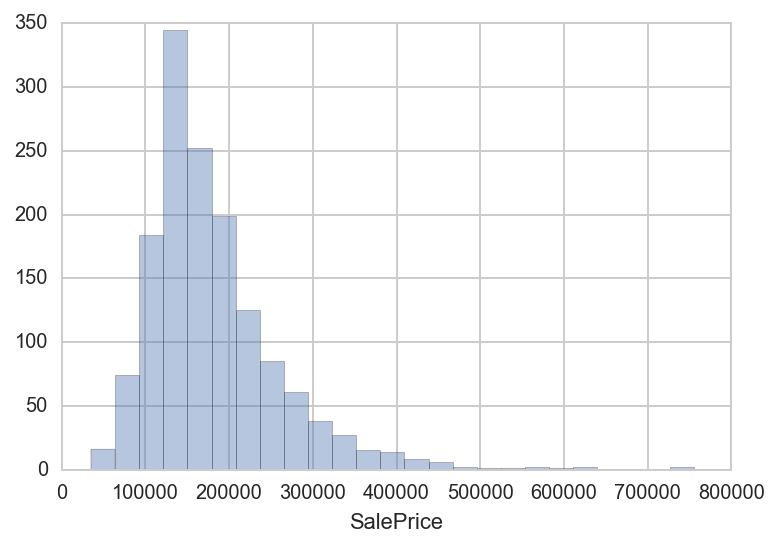

In [3]:
sns.distplot(house.SalePrice, kde=False, bins=25)

In [4]:
house.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### 2.2 Create a transformed version of the `SalesPrice` variable that makes it more normally distributed

Two common transformations to deal with long tails are taking the square root and taking the log of a variable. 

Plot the transformed variable.

In [5]:
house['logSalePrice'] = np.log(house.SalePrice+1)

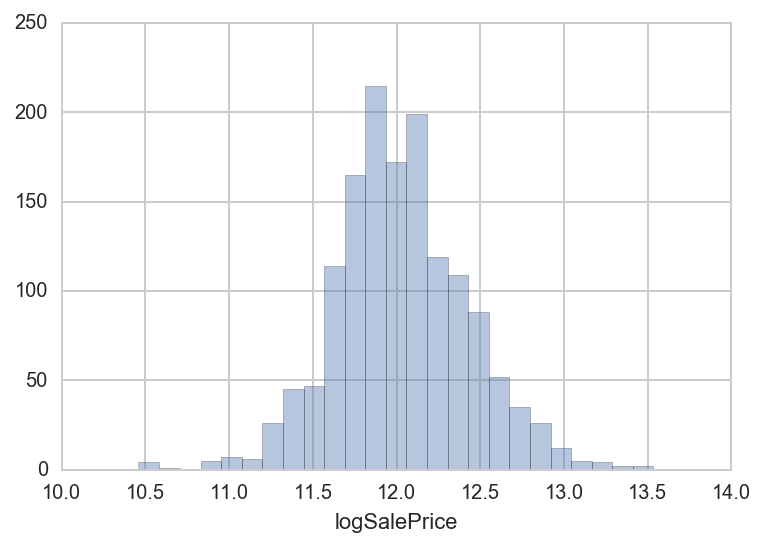

In [6]:
sns.distplot(house.logSalePrice, kde=False, bins=25)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Correlations with sale price

---

### 3.1 Correlate the age of a house when sold with the sale price

How is the correlation different when using the original and transformed sale price?


In [7]:
house['YrAgeWhenSold'] = (house.YrSold + (house.MoSold-1)/12.) - house.YearBuilt

In [8]:
np.corrcoef(house.YrAgeWhenSold, house.SalePrice)

array([[ 1.        , -0.52306324],
       [-0.52306324,  1.        ]])

In [9]:
np.corrcoef(house.YrAgeWhenSold, house.logSalePrice)

array([[ 1.        , -0.58692881],
       [-0.58692881,  1.        ]])

_The magnitude of correlation increases when the variable is transformed._

### 3.2 Plot the age of the house at sale against the sale price variables

How does it differ between the original and transformed variables? What do the charts indicate about the relationship between the variables?

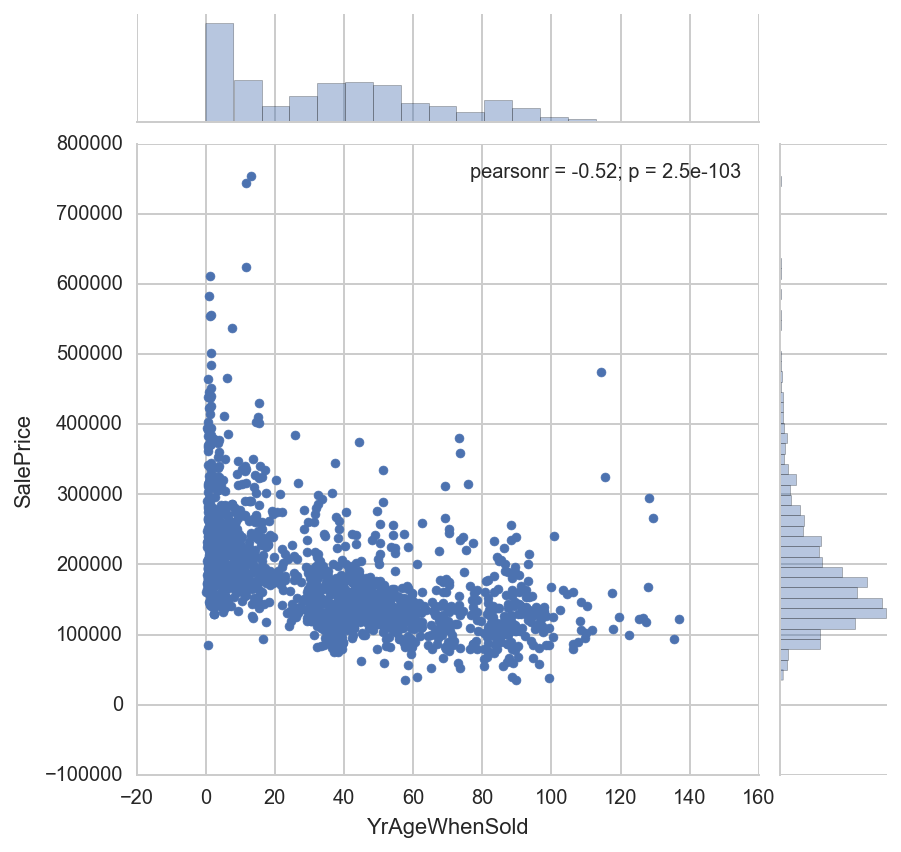

In [10]:
sns.jointplot(house.YrAgeWhenSold, house.SalePrice)

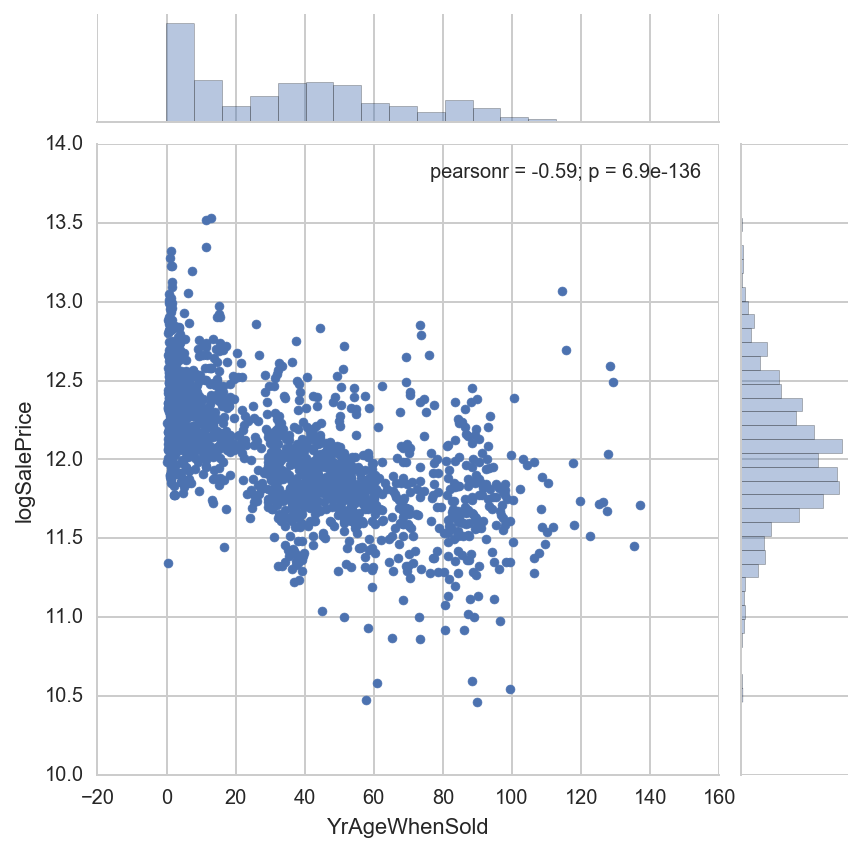

In [11]:
sns.jointplot(house.YrAgeWhenSold, house.logSalePrice)

### 3.3 Visually compare price to total livable square feet, `GrLivArea`

What is the relationship, if any?

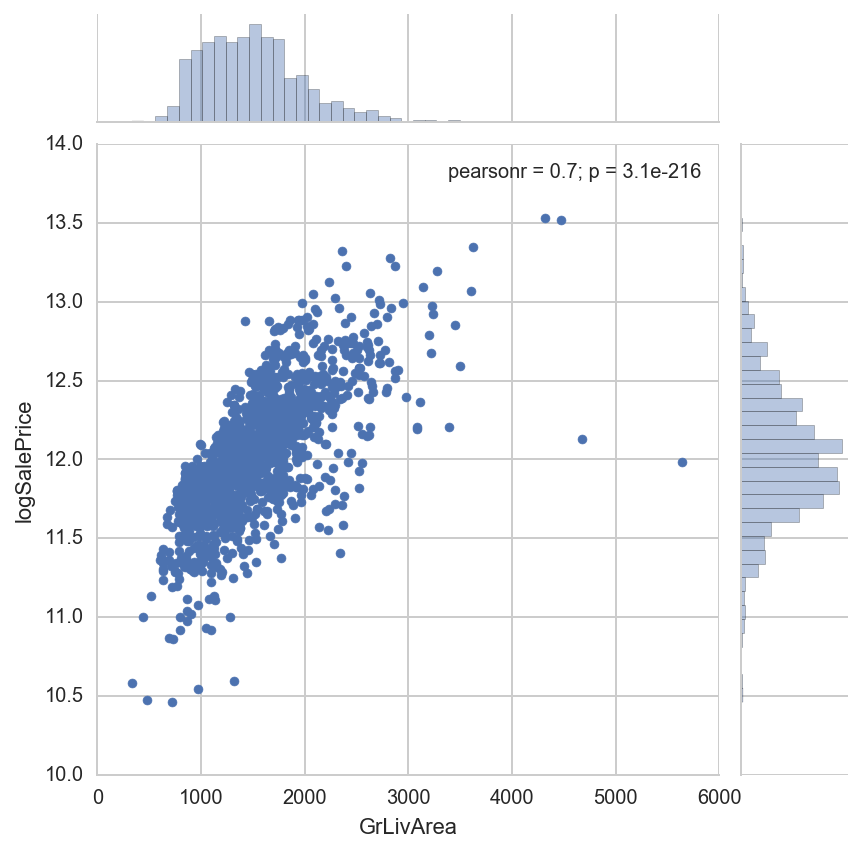

In [12]:
sns.jointplot(house.GrLivArea, house.logSalePrice)

_There is a strong positive relationship between livable space and sale price._

### 3.4 Plot and describe the relationship between two continuous variables of your choice in the data

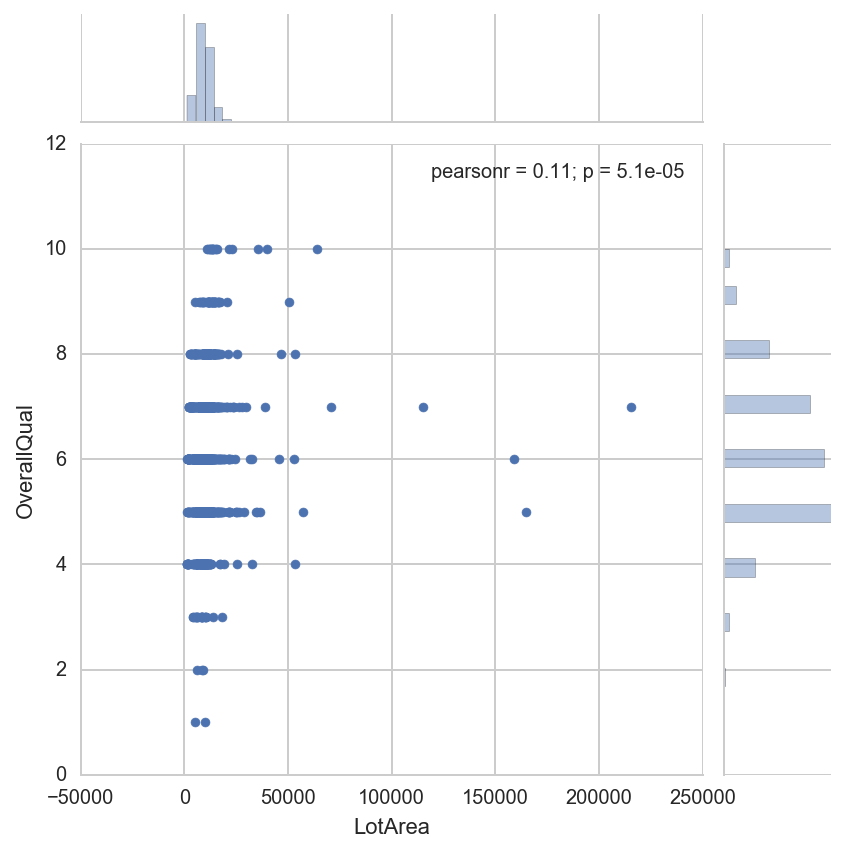

In [13]:
sns.jointplot(house.LotArea, house.OverallQual)

_There may be a small positive relationship between lot area and overall quality of the house (rated on 1-10, so not purely continuous - this is an ordinal variable.)_

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Data transformation and quality assessment

---

**Note: from this point onward, you can use your transformed price variable or the original price variable. Up to you. It will change the interpretation of the coefficients in your model.**

### 4.1 Restrict the data 

Only keep houses that are residential (remove the commercial code buildings).

In [14]:
print house.shape
house = house[house.MSZoning.isin(['RL','RM','FV','RH'])]
print house.shape

(1460, 83)
(1450, 83)


### 4.2 Handle null values in the dataset

Many of the variables contain null values. In many of these cases the null value is actually representative of a category that is a level of a categorical variable.

Eliminate the null values from your dataset, explaining your rationale for each variable. You have options for null values:

- Replace the null values (impute).
- Drop the observation.
- Drop the variable. 

In [15]:
# Find out which variables have null values.
nulls = house.isnull().sum()[house.isnull().sum() > 0]
nulls

LotFrontage      259
Alley           1361
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      681
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1443
Fence           1172
MiscFeature     1398
dtype: int64

In [16]:
# Remove Alley, PoolQC, Fence, and MiscFeature, since the majority of their
# observations are nulls.
house.drop(['Alley','PoolQC','Fence','MiscFeature'], axis=1, inplace=True)

In [17]:
# Drop the rows for MasVnrType, MasVnrArea, and Electrical. There aren't many
# of them.
house = house[~house.MasVnrType.isnull() & ~house.MasVnrArea.isnull() & ~house.Electrical.isnull()]

In [18]:
# Look at the different basement variables:
house.BsmtQual.value_counts()

TA    638
Gd    611
Ex    120
Fa     35
Name: BsmtQual, dtype: int64

In [19]:
house.BsmtCond.value_counts()

TA    1295
Gd      64
Fa      43
Po       2
Name: BsmtCond, dtype: int64

In [20]:
house.BsmtExposure.value_counts()

No    939
Av    219
Gd    133
Mn    112
Name: BsmtExposure, dtype: int64

In [21]:
house.BsmtFinType1.value_counts()

Unf    421
GLQ    413
ALQ    220
BLQ    147
Rec    129
LwQ     74
Name: BsmtFinType1, dtype: int64

In [22]:
house.BsmtFinType2.value_counts()

Unf    1237
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [23]:
# All the basement variables are categorical, so fill in the missing values
# with 'unknown':
for col in ['BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2','BsmtExposure']:
    house.loc[house[col].isnull(), col] = 'unknown'

In [24]:
# Look at the garage variables:

In [25]:
house.GarageQual.value_counts()

TA    1294
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64

In [26]:
house.GarageCond.value_counts()

TA    1310
Fa      34
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [27]:
house.GarageType.value_counts()

Attchd     863
Detchd     381
BuiltIn     86
Basment     18
CarPort      8
2Types       6
Name: GarageType, dtype: int64

In [28]:
house.GarageYrBlt.value_counts()

2005.0    65
2006.0    58
2004.0    53
2003.0    49
2007.0    45
1977.0    35
1998.0    31
1999.0    30
1976.0    29
2008.0    29
2000.0    27
1968.0    26
1950.0    24
2002.0    24
1993.0    22
2009.0    21
1965.0    21
1966.0    21
1962.0    21
1957.0    20
1958.0    20
1970.0    20
2001.0    20
1996.0    20
1954.0    19
1997.0    19
1960.0    19
1978.0    19
1974.0    18
1995.0    18
          ..
1951.0     6
1916.0     5
1922.0     5
1936.0     5
1945.0     4
1946.0     4
1935.0     4
1931.0     4
1982.0     4
1928.0     4
1921.0     3
1923.0     3
1924.0     3
1910.0     3
2010.0     3
1932.0     3
1938.0     3
1929.0     2
1934.0     2
1937.0     2
1942.0     2
1918.0     2
1947.0     2
1915.0     2
1914.0     2
1952.0     2
1927.0     1
1933.0     1
1908.0     1
1906.0     1
Name: GarageYrBlt, dtype: int64

In [29]:
house.GarageFinish.value_counts()

Unf    600
RFn    415
Fin    347
Name: GarageFinish, dtype: int64

In [30]:
# Impute the garage year built with the mean year. For the other garage variables,
# put in the 'unknown' label like for the basement variables above.
house.loc[house.GarageYrBlt.isnull(), 'GarageYrBlt'] = np.nanmean(house.GarageYrBlt)

for col in ['GarageFinish','GarageCond','GarageQual','GarageType']:
    house.loc[house[col].isnull(), col] = 'unknown'

In [31]:
# Impute lot frontage using a regression. Take all of the square feet related variables and the 
# lot area variable to include in the regression.
lot_reg_vars = ['LotArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                '1stFlrSF','2ndFlrSF','LowQualFinSF','WoodDeckSF','OpenPorchSF']
lot_valid = house[~house.LotFrontage.isnull()]
lot_y = lot_valid.LotFrontage.values
lot_X = lot_valid[lot_reg_vars]

In [32]:
# Build a regression predicting the lot frontage from the area variables.
from sklearn.linear_model import LinearRegression
lot_reg = LinearRegression().fit(lot_X, lot_y)

//anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [33]:
# predict for the missing lot variables.
lot_pred_X = house[house.LotFrontage.isnull()][lot_reg_vars]
lot_pred = lot_reg.predict(lot_pred_X)

# add some random noise the same standard deviation as the residuals
# from the regression model.
lot_resid_sd = np.std(lot_y - lot_reg.predict(lot_X))
print lot_resid_sd
lot_pred = lot_pred + np.random.normal(0, lot_resid_sd, size=len(lot_pred))

# Fill in the missing lot values with the predictions plus noise.
house.loc[house.LotFrontage.isnull(), "LotFrontage"] = lot_pred

20.135889886


In [34]:
# replace the null fireplace quality entries with 'unknown'
house.loc[house.FireplaceQu.isnull(), 'FireplaceQu'] = 'unknown'

In [35]:
# confirm all nulls are gone:
house.isnull().sum().sum()

0

### 4.3 Remove any variables you think are not viable to use as predictors of price.

This can be a subjective process. A common criterion is to remove variables that have little to no variance. This would be, for example, a  variable where nearly all observations were in a single category or had a single value. 

For each variable you remove (if any), explain your rationale for why.

In [37]:
# Take a look at all the categorical variables by printing them out:
for col in house.columns:
    if len(house[col].unique()) < 20:
        print house[col].value_counts()
        print '----------------------------------------------------------------'
        
# To drop:
# Street : only 4 of category Grvl (drop)
# Utilities : drop, only one with no sewage
# Condition2 : most all one type
# RoofMatl : drop, almost all in 1 category
# Heating: too few in other categories
# PoolArea: only 7 have pools, though I could see this being important.
# PoolQC: drop since only 7 pools
# MiscFeature: drop, keep MiscVal instead

for col in ['Street','Utilities','Condition2','RoofMat1','Heating','PoolArea','PoolQC','MiscFeature']:
    try:
        house.drop(col, axis=1, inplace=True)
    except:
        pass


20     530
60     296
50     140
120     86
30      67
160     63
70      59
80      57
90      52
190     29
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
----------------------------------------------------------------
RL    1145
RM     218
FV      62
RH      16
Name: MSZoning, dtype: int64
----------------------------------------------------------------
Pave    1437
Grvl       4
Name: Street, dtype: int64
----------------------------------------------------------------
Reg    909
IR1    481
IR2     41
IR3     10
Name: LotShape, dtype: int64
----------------------------------------------------------------
Lvl    1296
Bnk      62
HLS      49
Low      34
Name: LandContour, dtype: int64
----------------------------------------------------------------
AllPub    1440
NoSeWa       1
Name: Utilities, dtype: int64
----------------------------------------------------------------
Inside     1037
Corner      260
CulDSac      93
FR2          47
FR3        

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. Plot a correlation matrix between the continuous variables

---

**Some columns in the DataFrame are numeric type, but that doesn't necessarily mean that they are continuous. Sometimes numeric values are used to represent the levels of a categorical variable.**

To plot a correlation matrix, it is popular to represent the correlation values using hue with a "heatmap". 

Describe anything interesting or notable you observe from the correlation matrix.

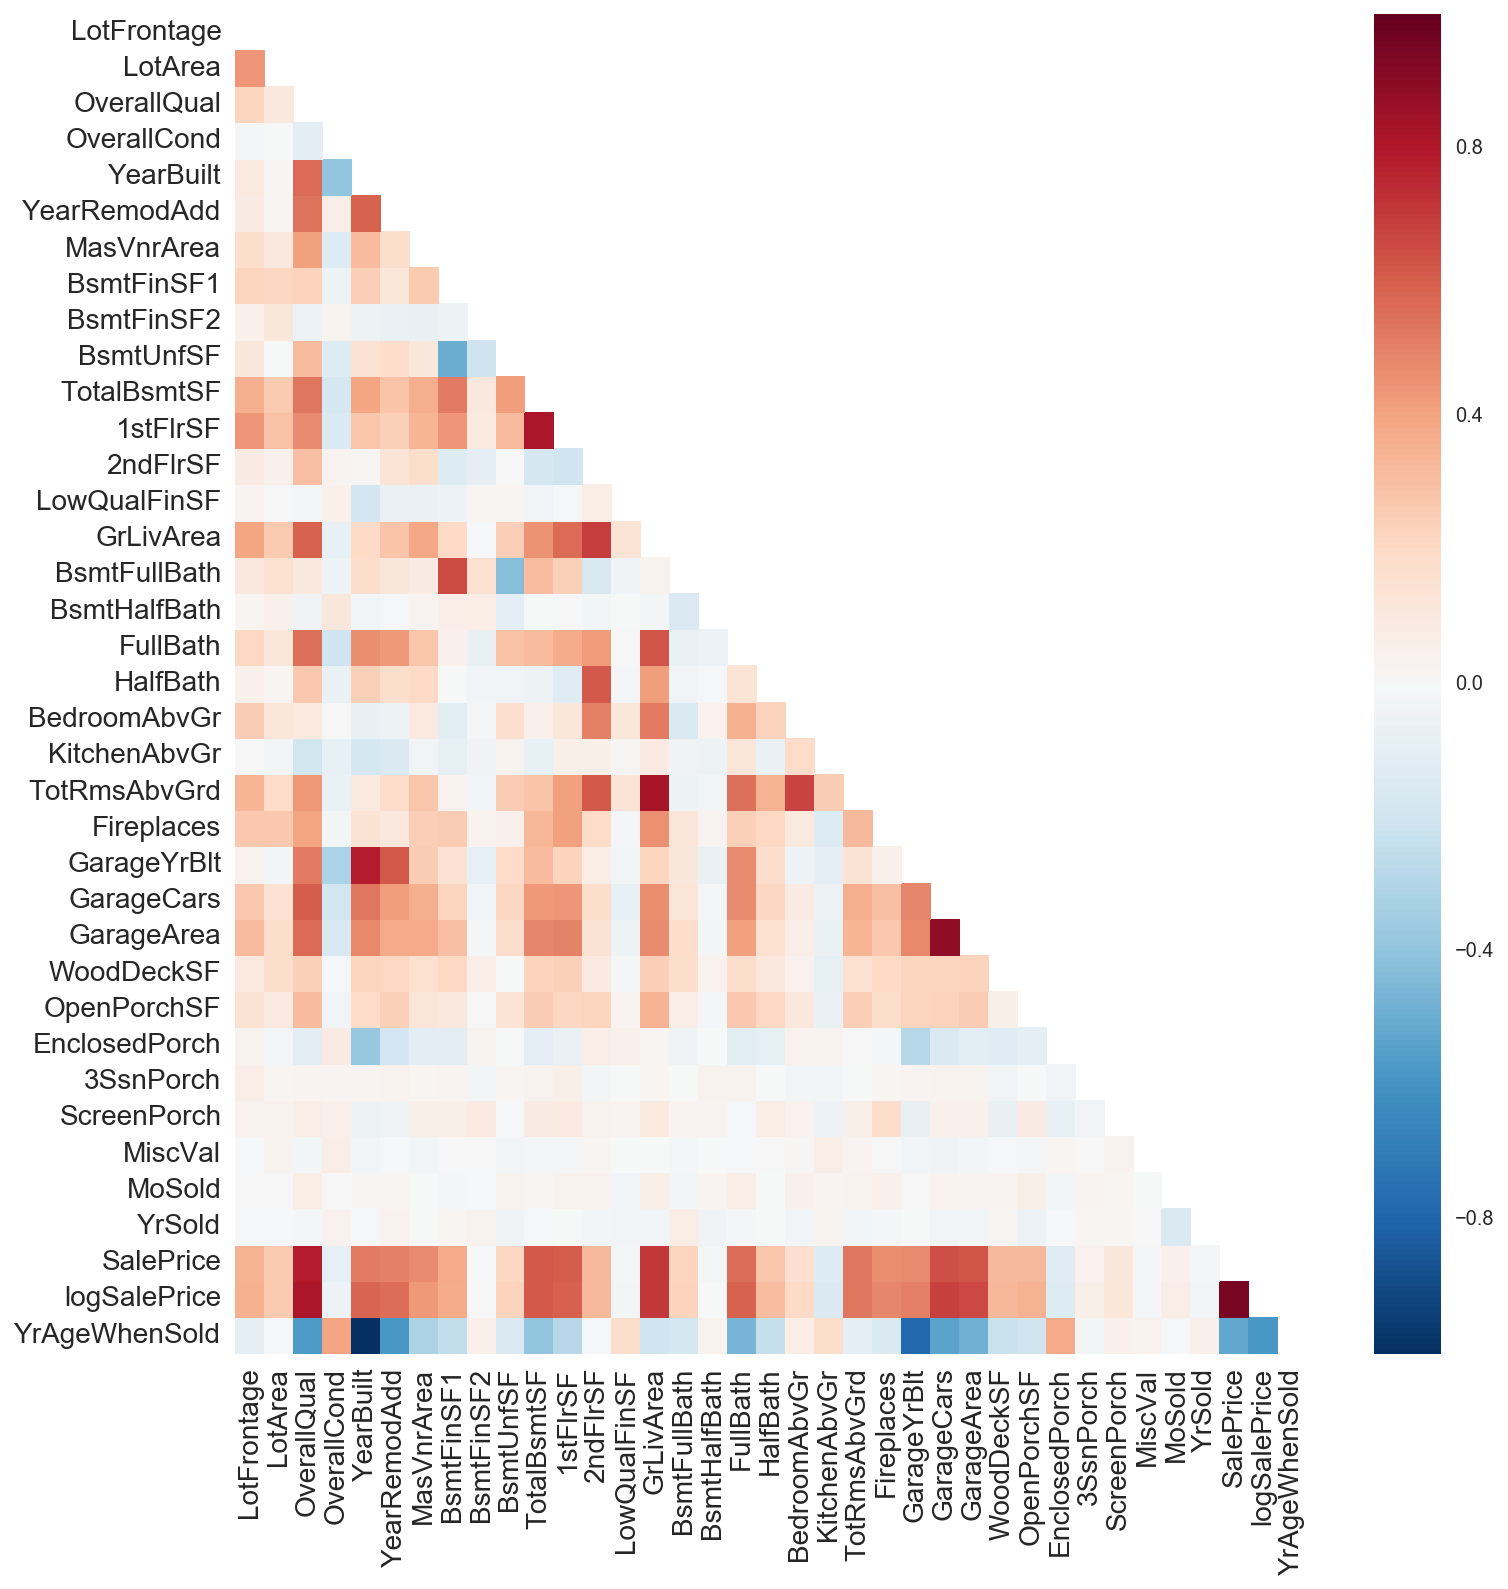

In [38]:
numeric_cols = [col for col in house.columns if house[col].dtype in [float, int]]
numeric_cols = [x for x in numeric_cols if not x in ['Id', 'MSSubClass']]

numeric_subset = house[numeric_cols]
corrs = numeric_subset.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(12,12))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrs, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 6. Make boxplots of categorical variables against the sale price

---

You don't have to plot all of them unless you want to. Make at least 8 boxplots looking at the distribution of sale price across levels of categorical variables in your dataset. This can be whichever categorical variables interest you the most.

In [39]:
# turn MSSubClass into categorical:
house.MSSubClass = house.MSSubClass.map(lambda x: str(x))

In [40]:
cat_cols = [col for col in house.columns if house[col].dtype not in [float, int]]

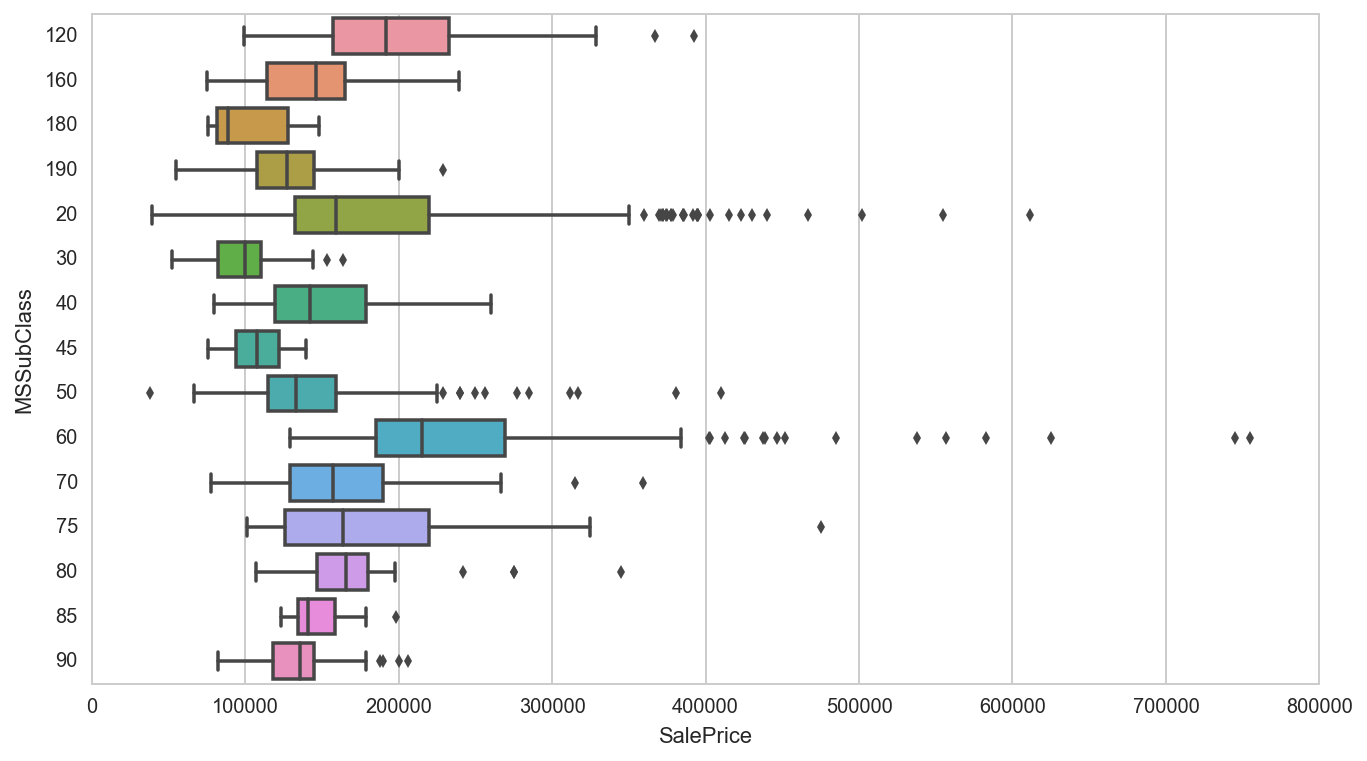

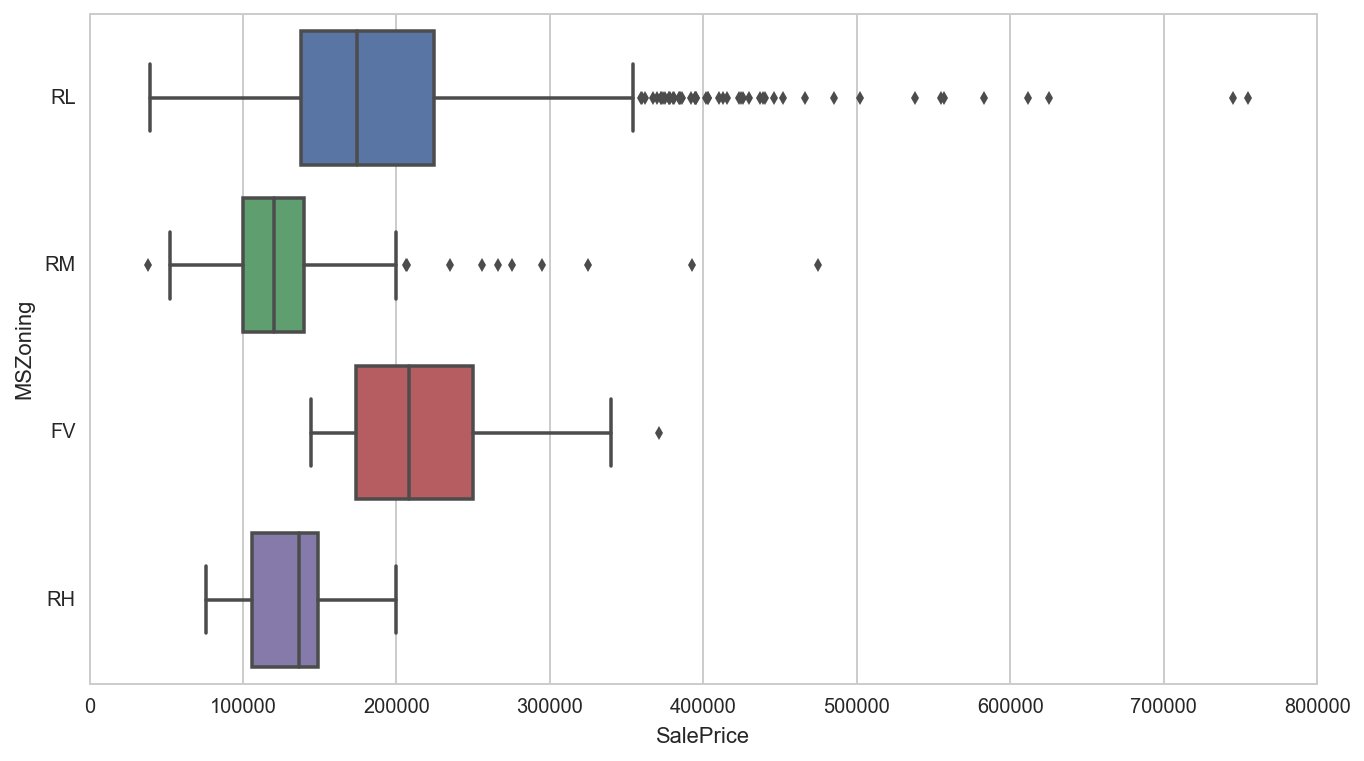

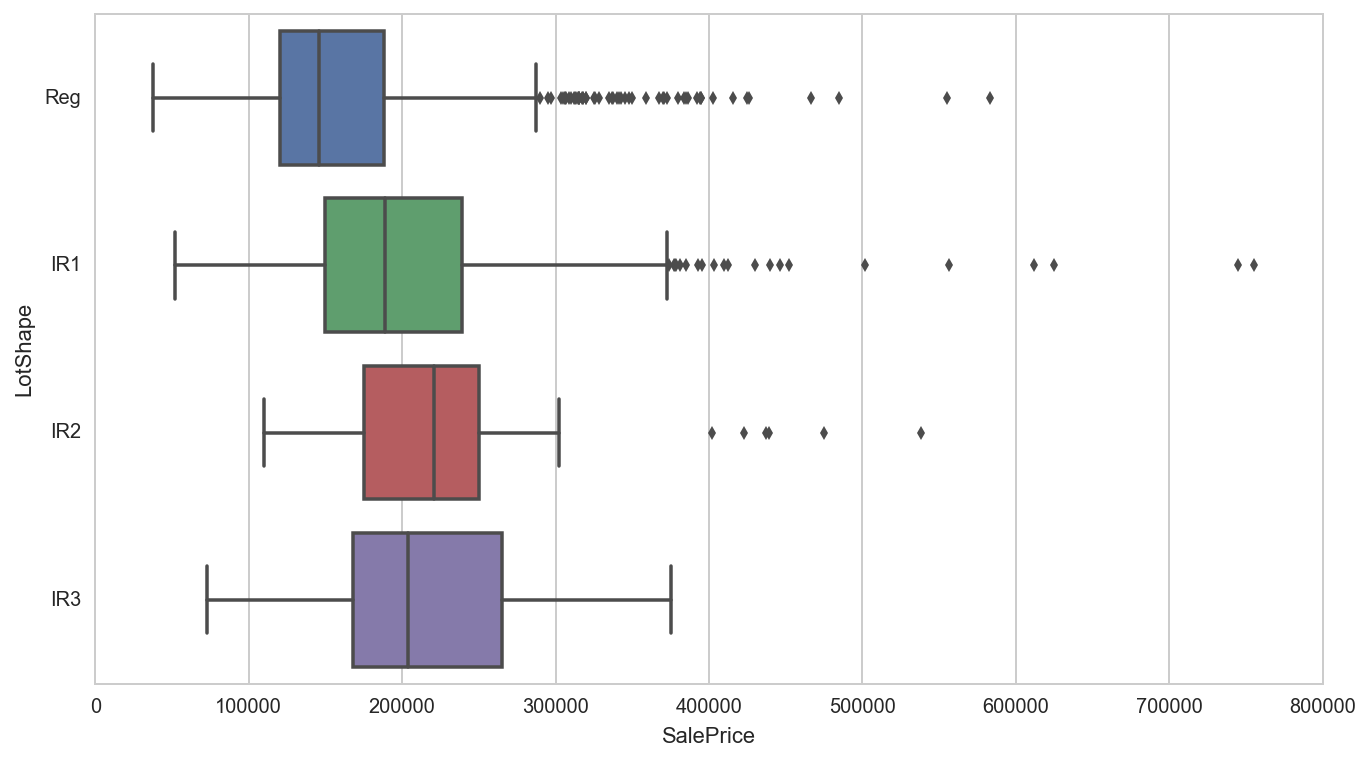

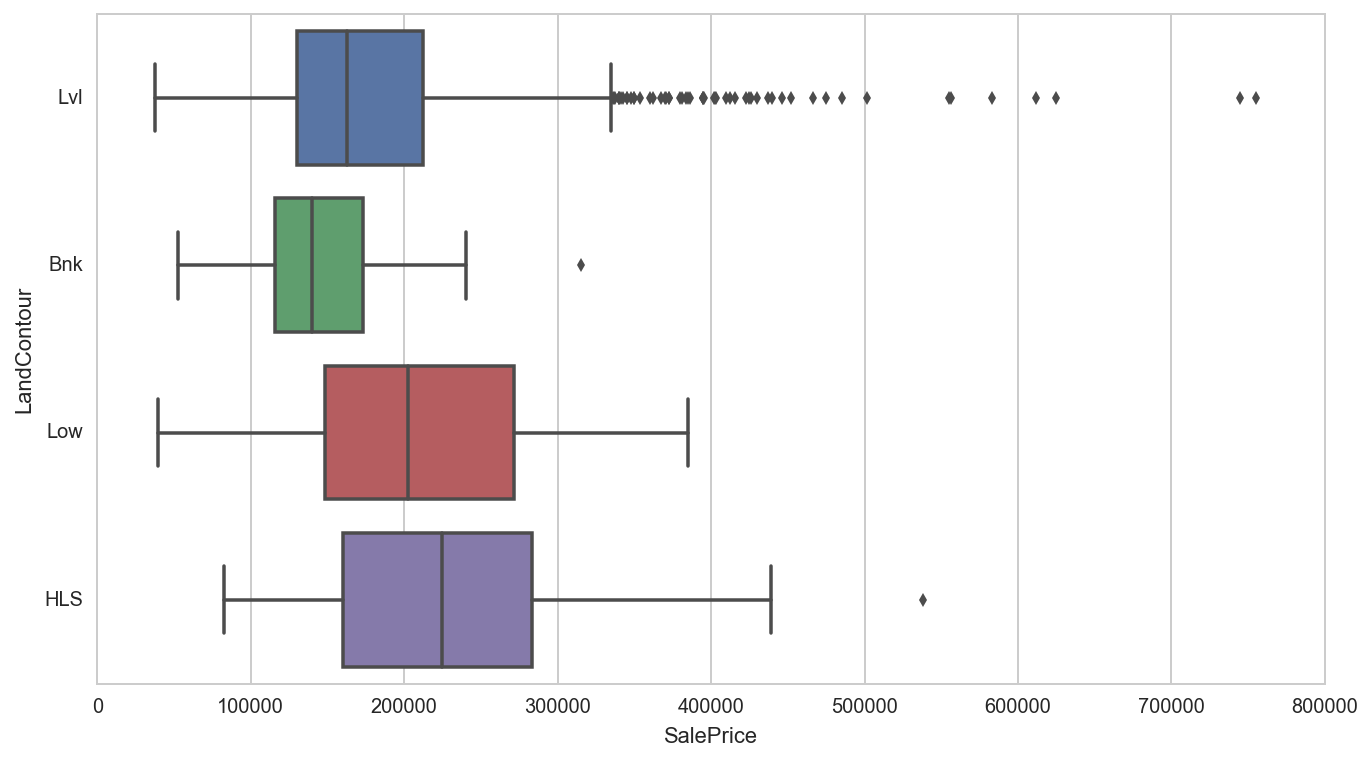

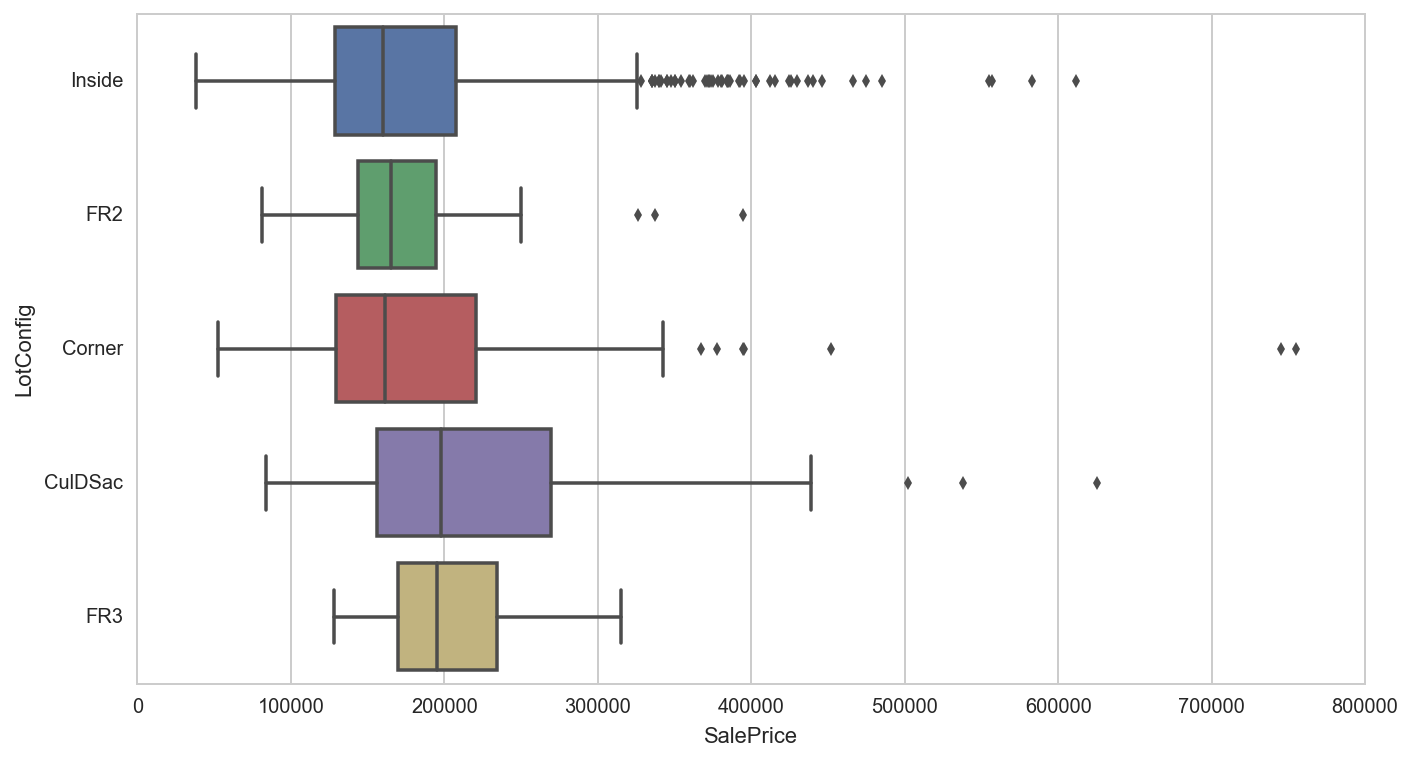

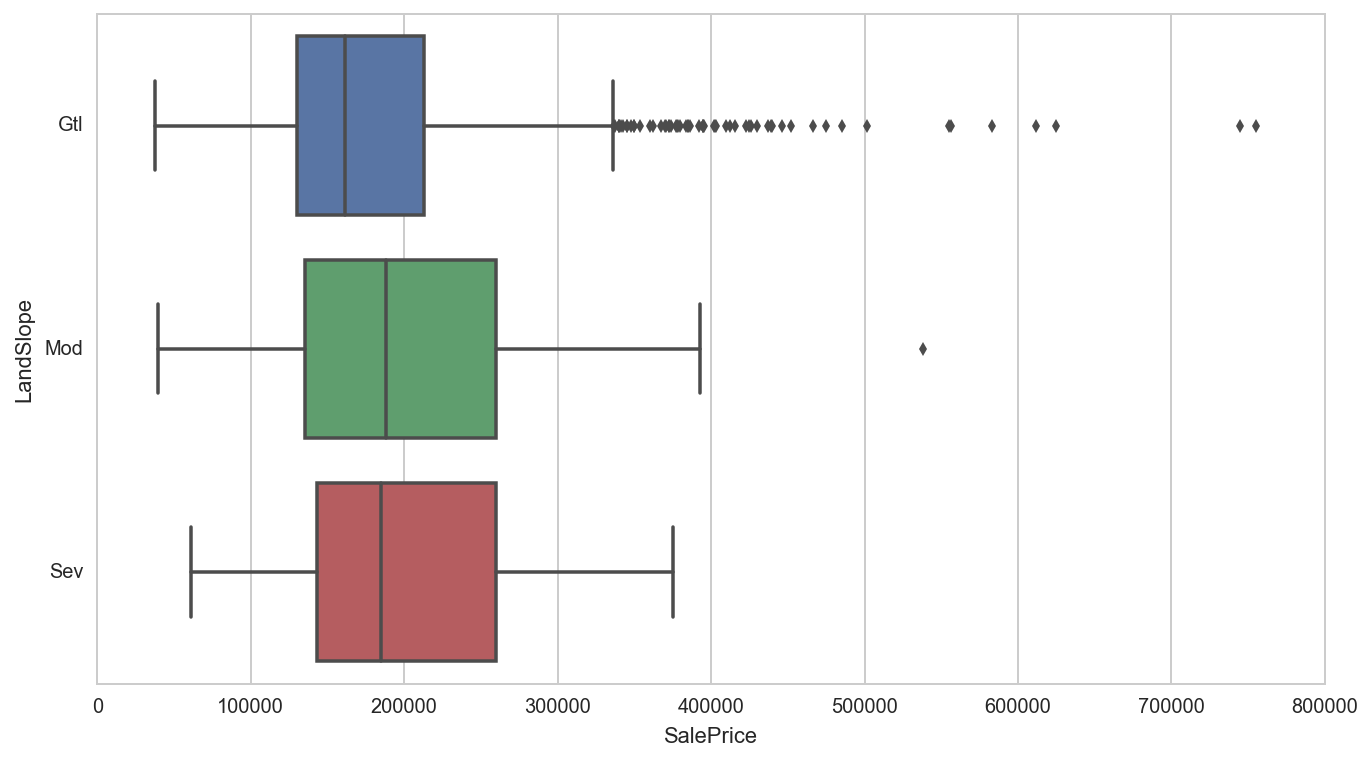

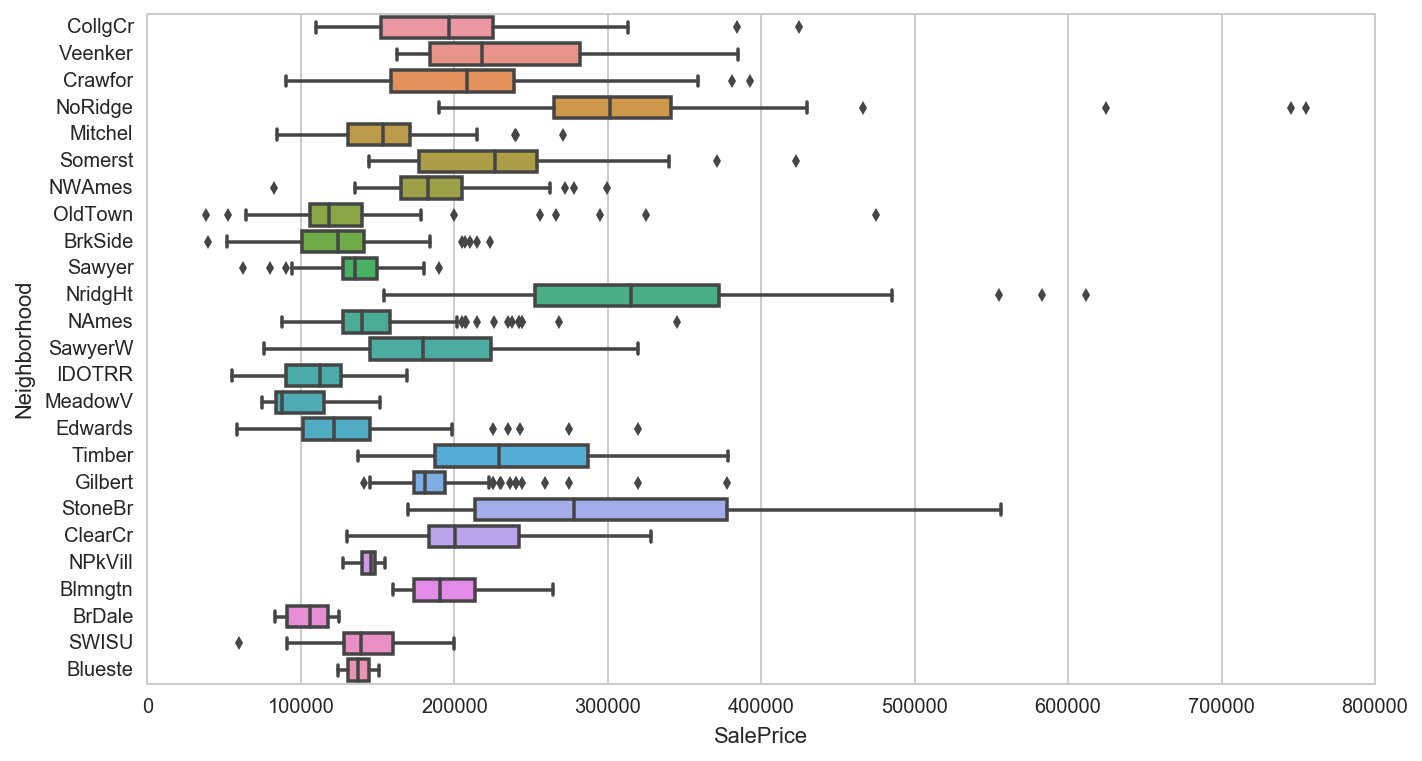

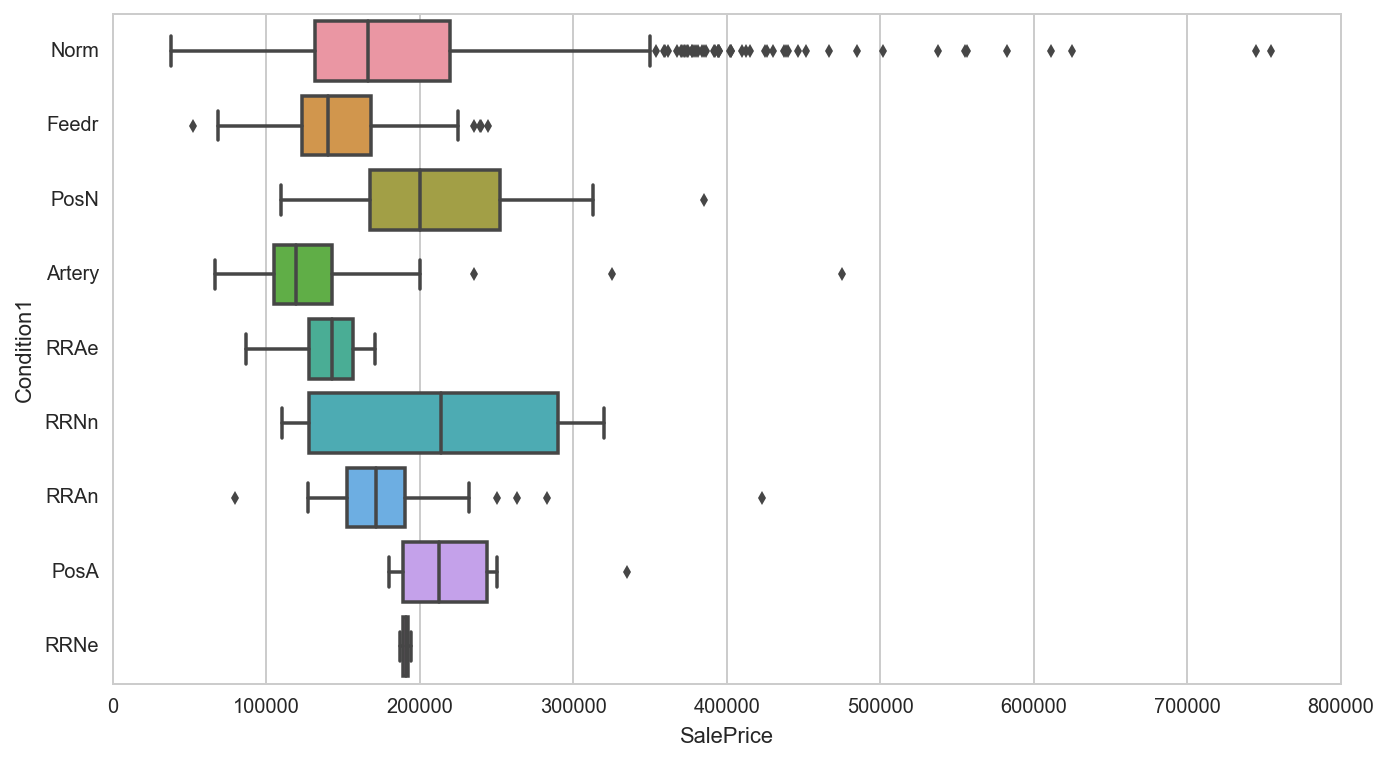

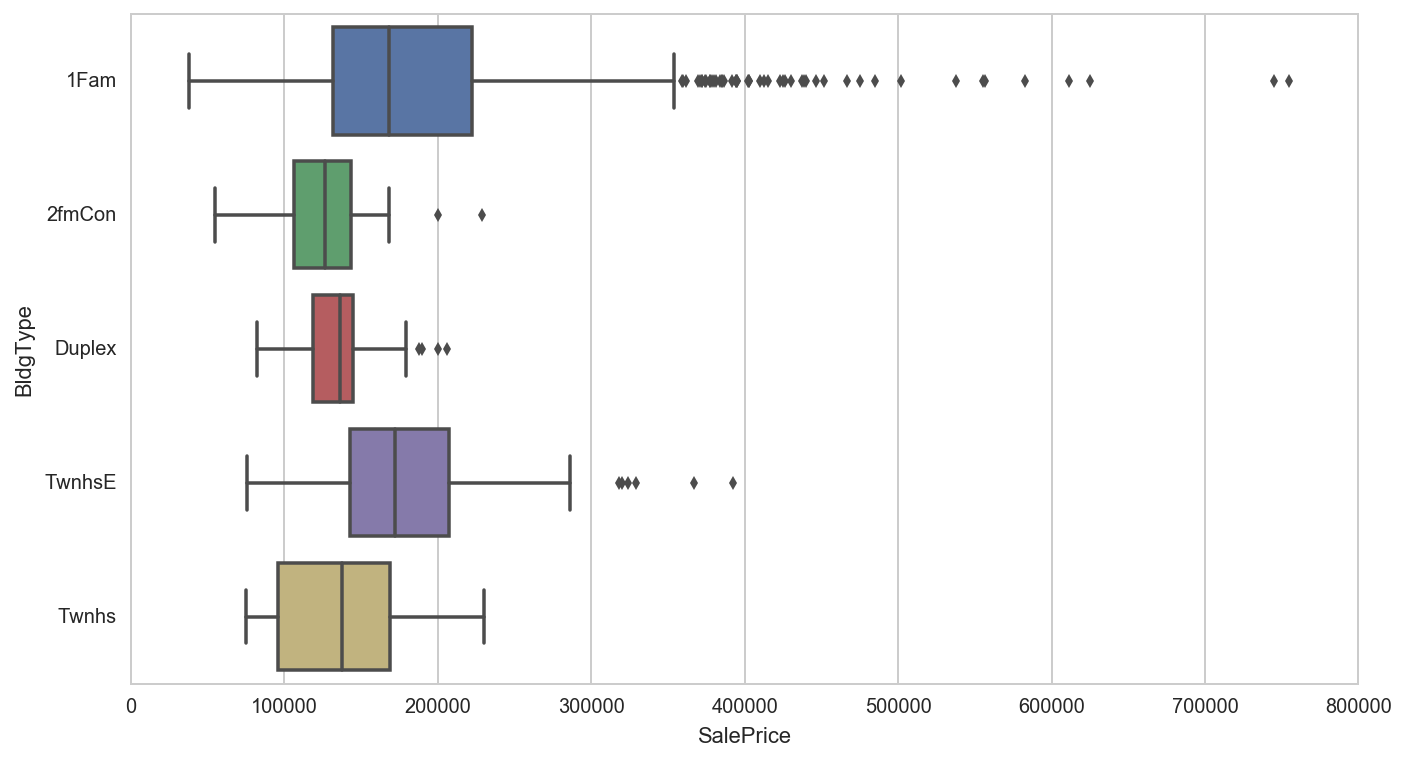

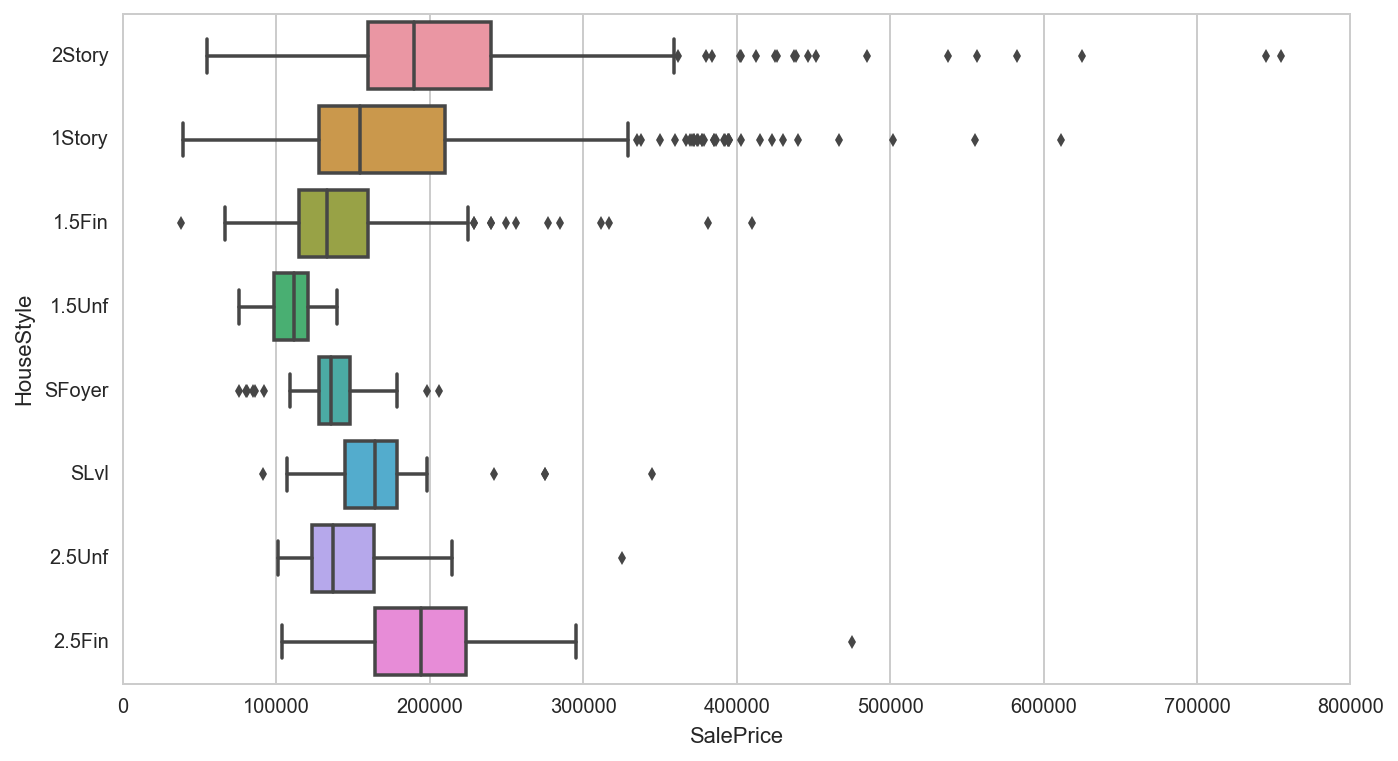

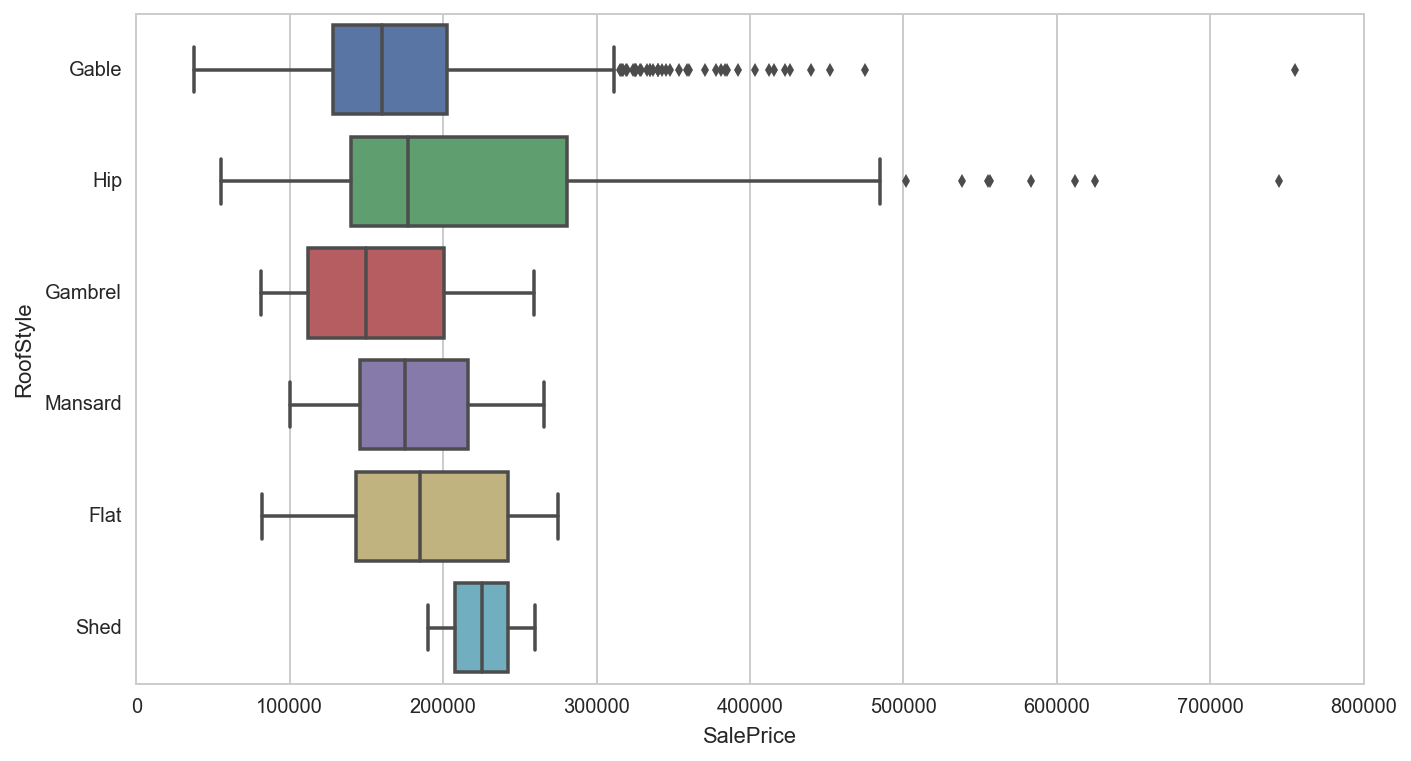

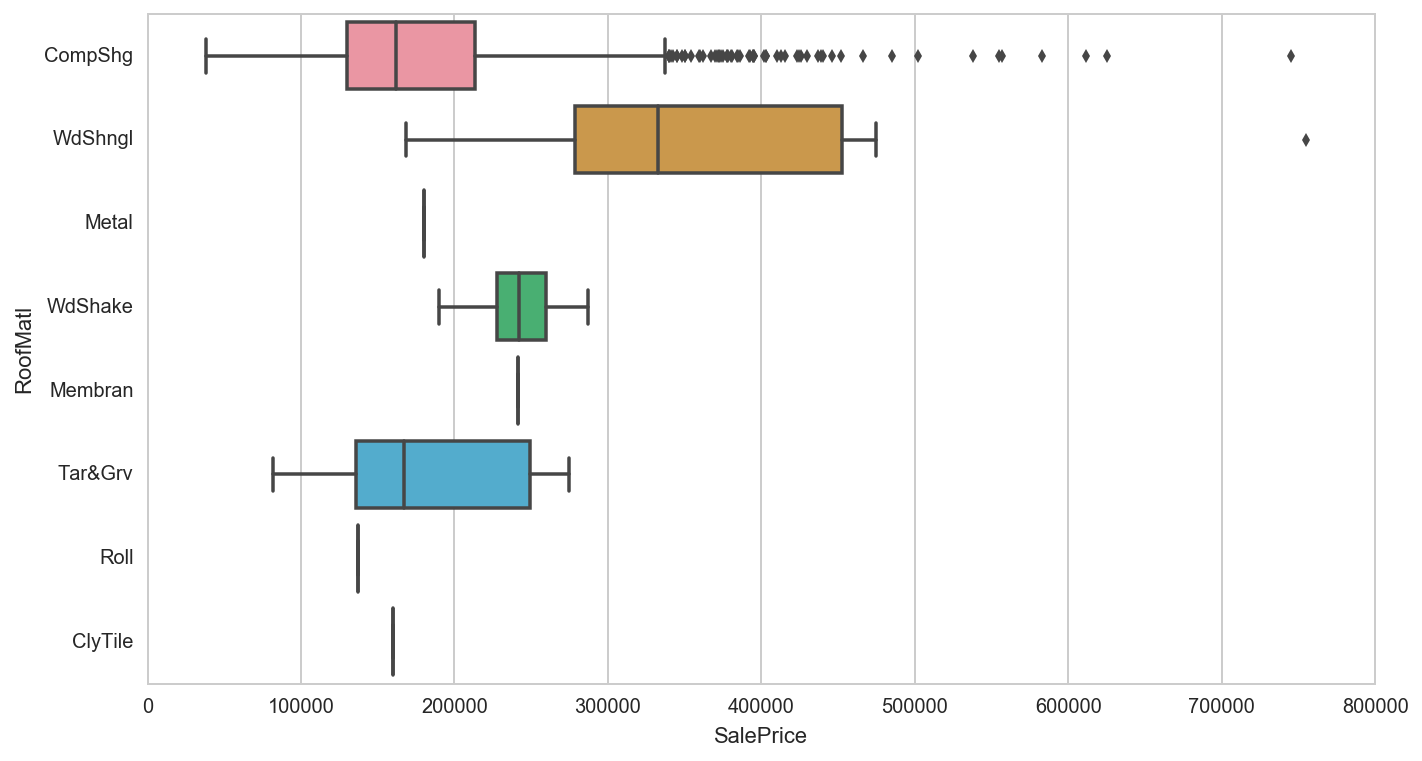

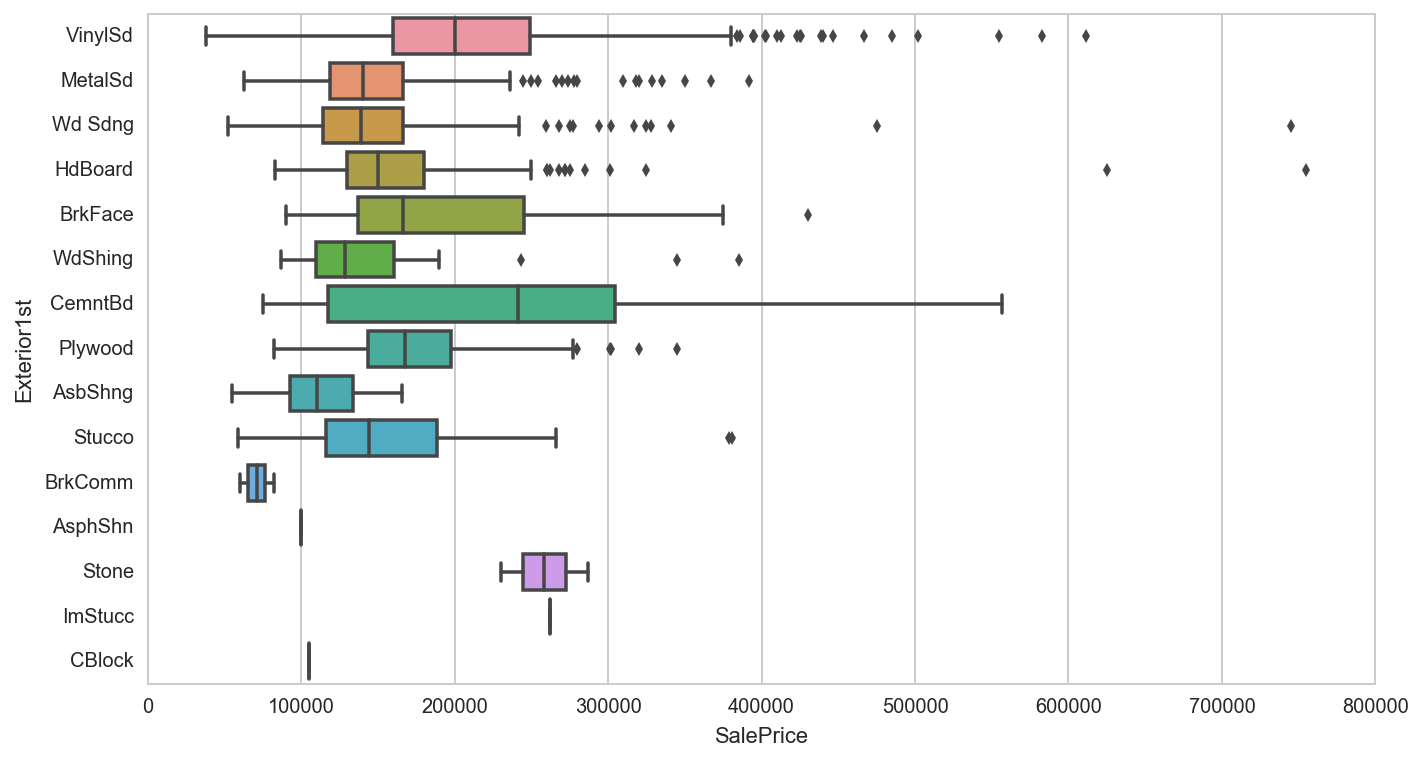

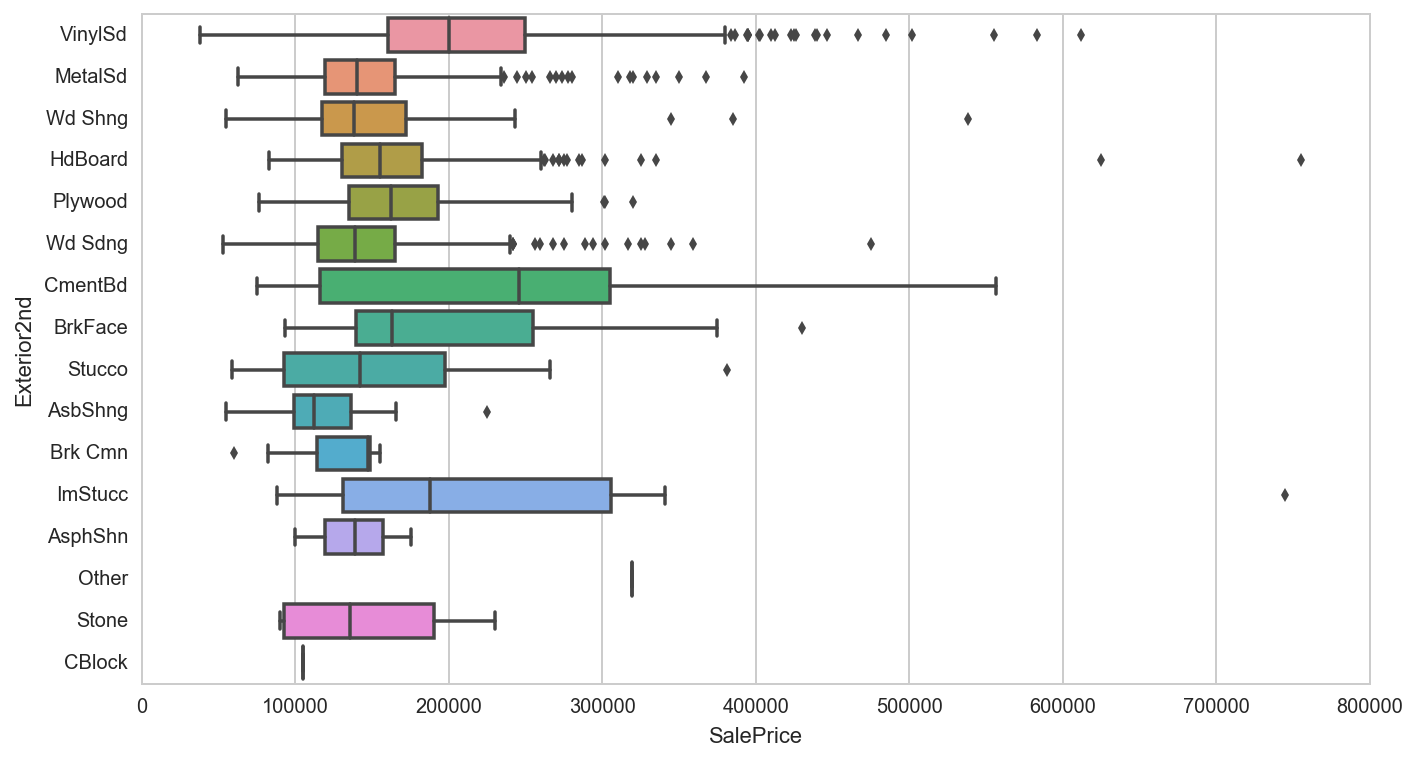

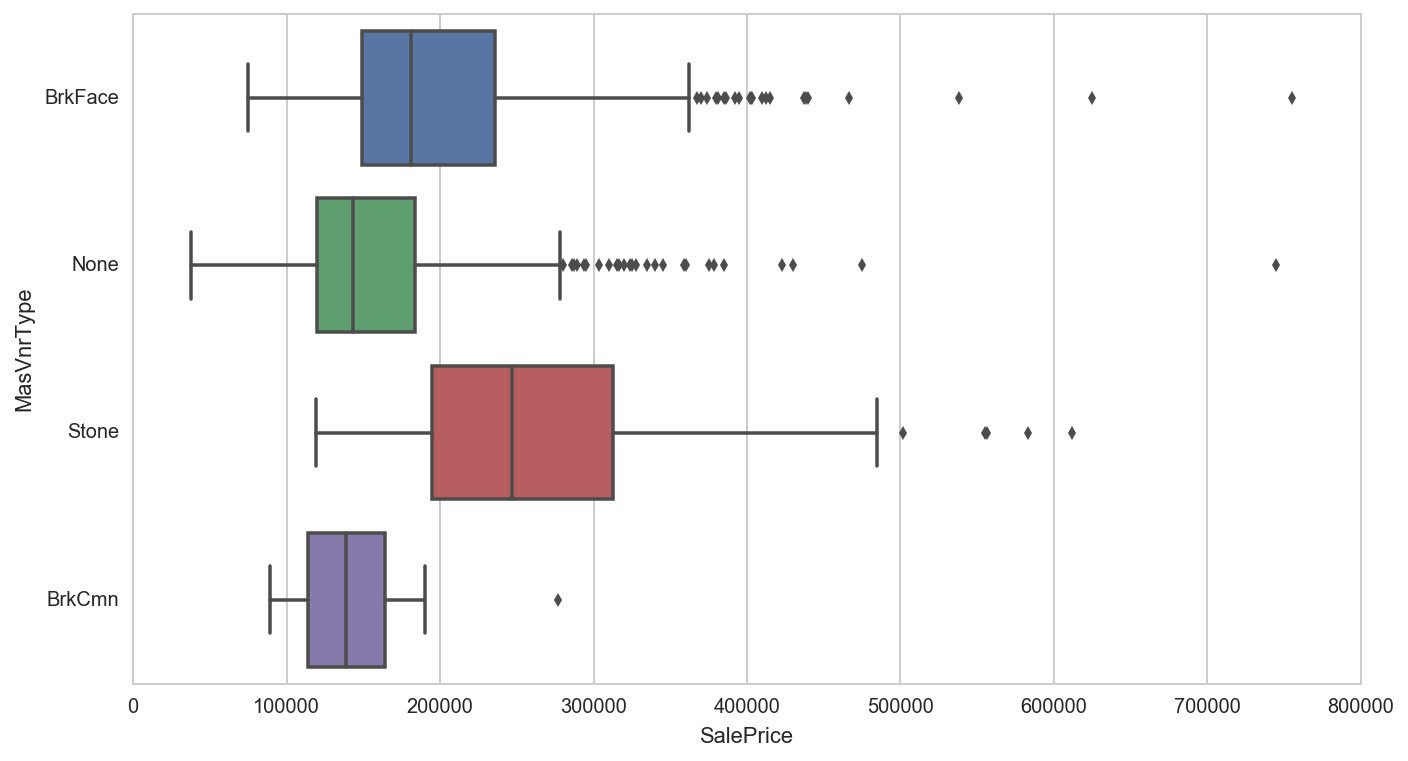

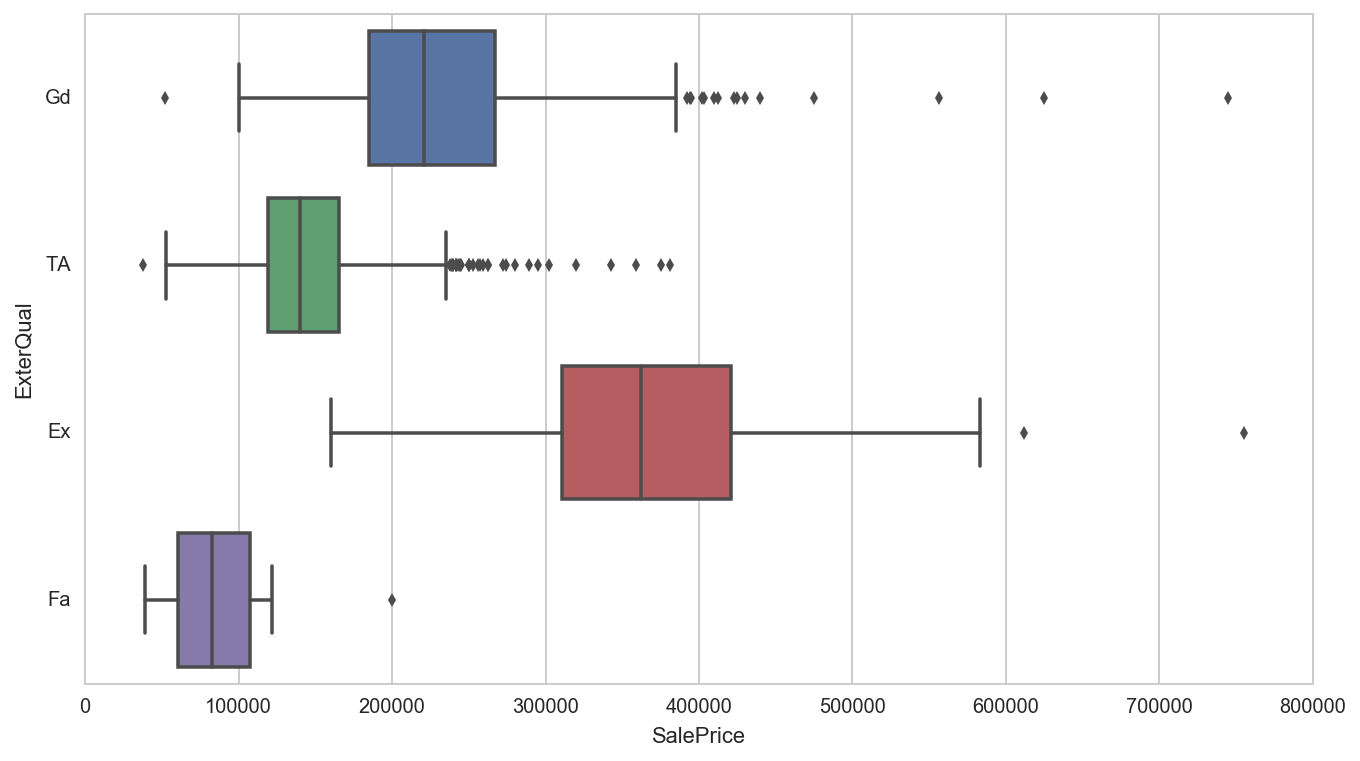

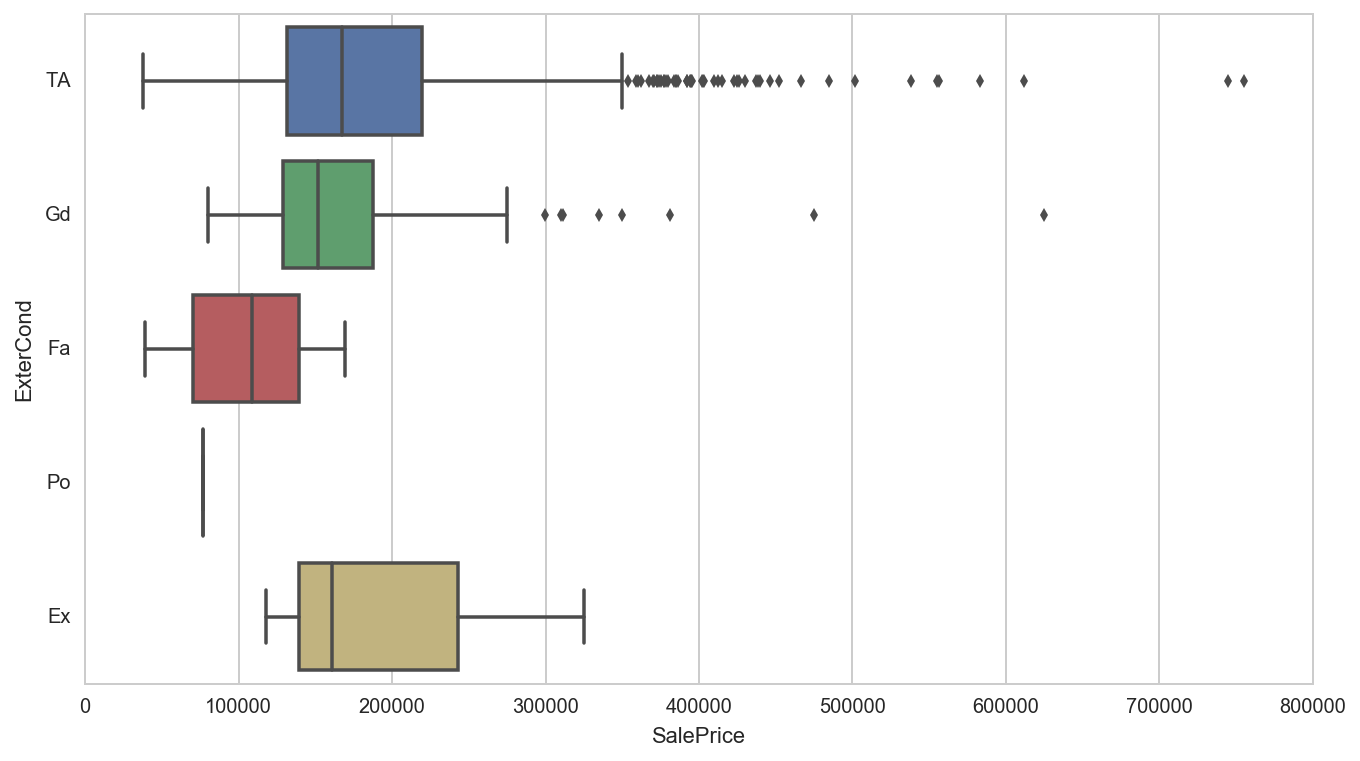

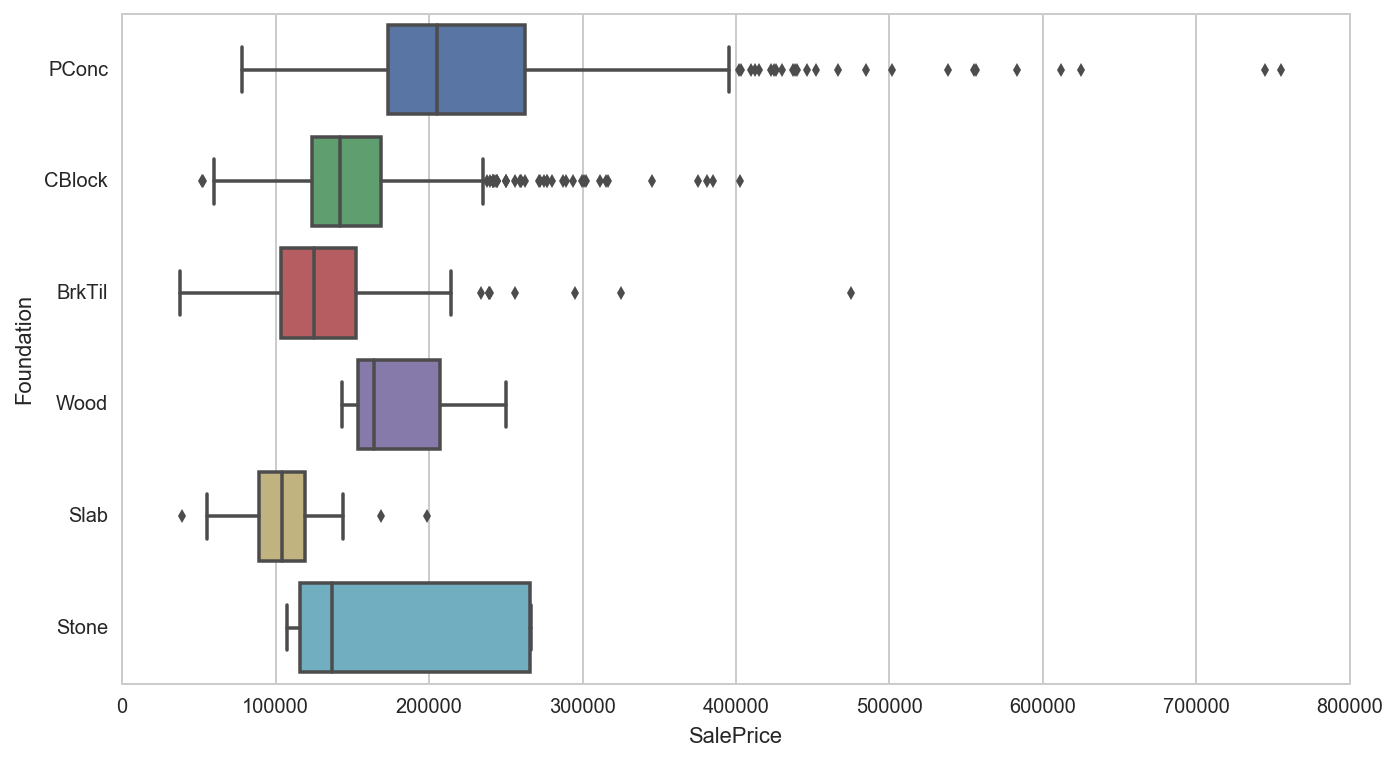

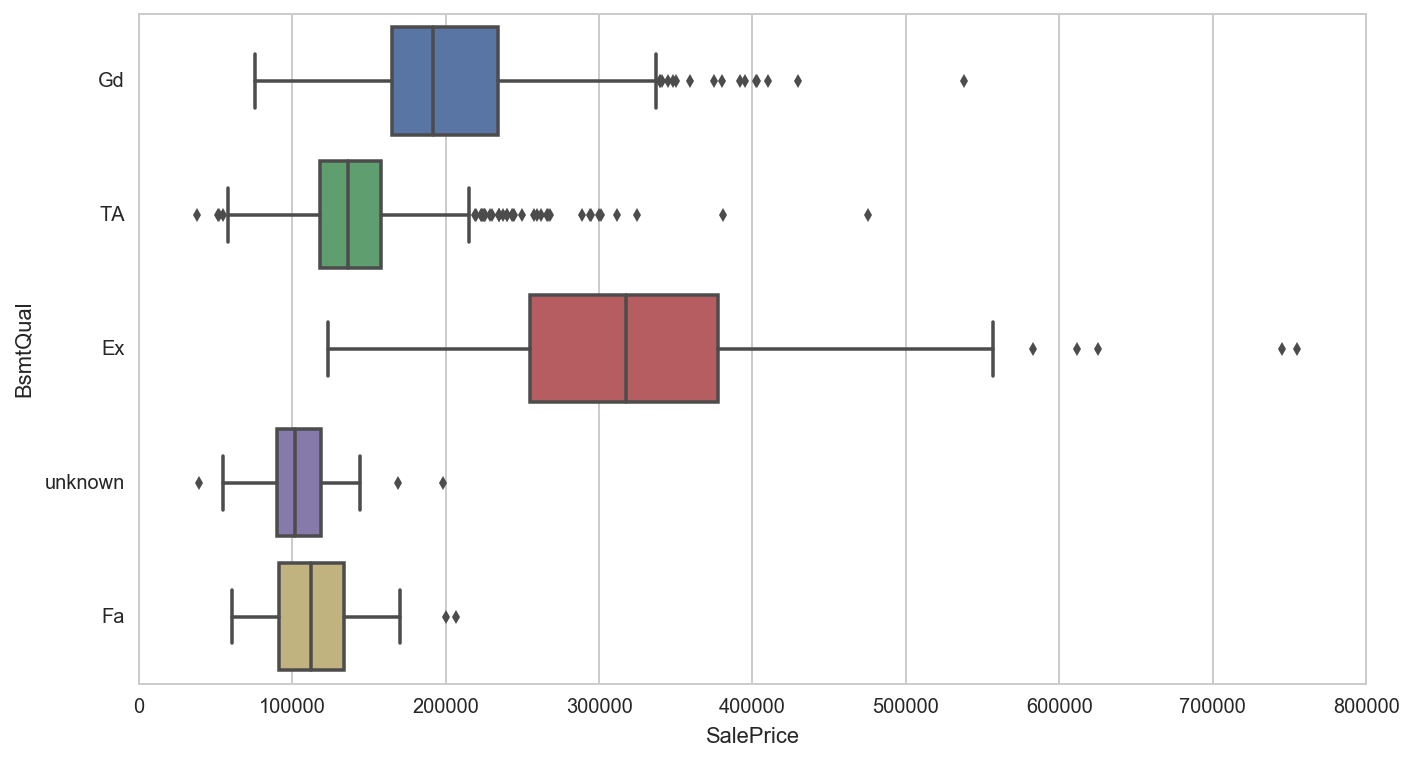

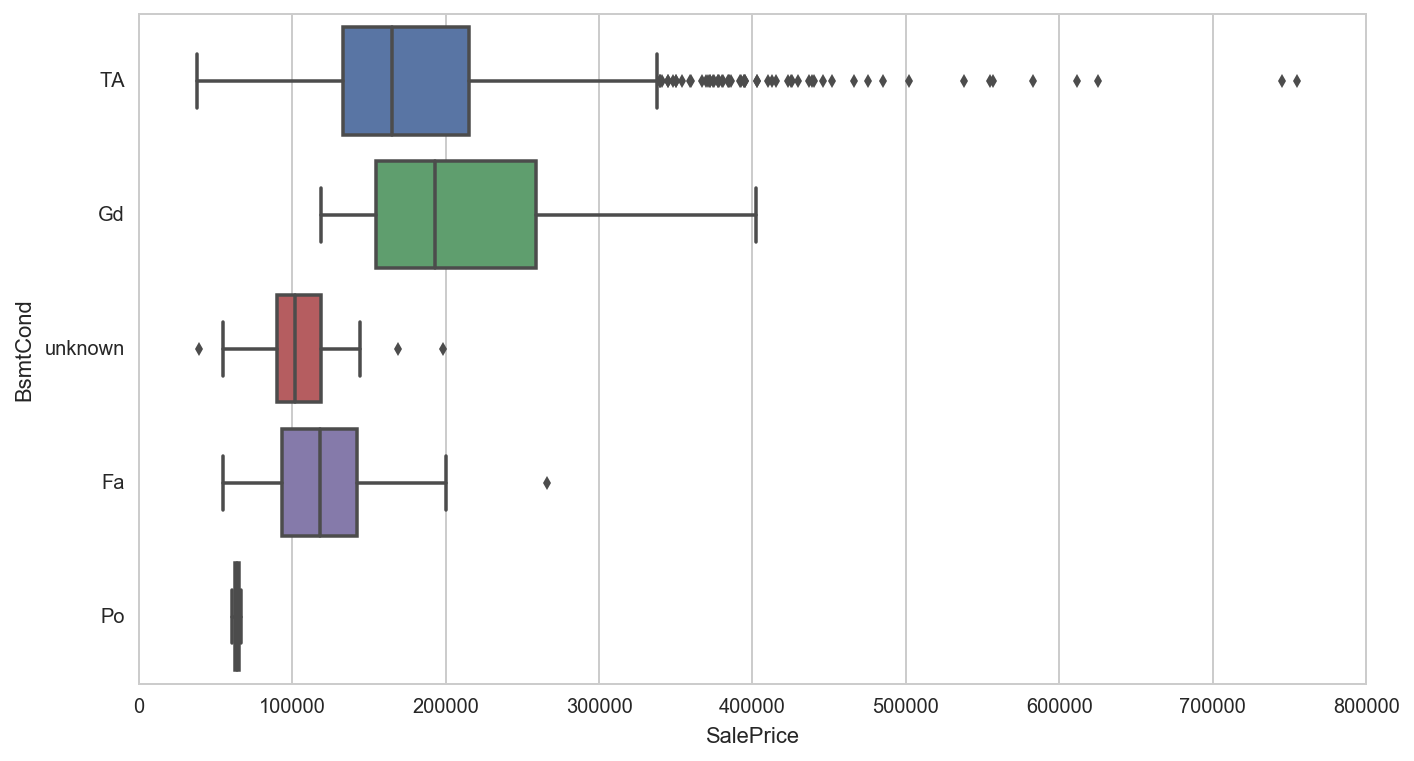

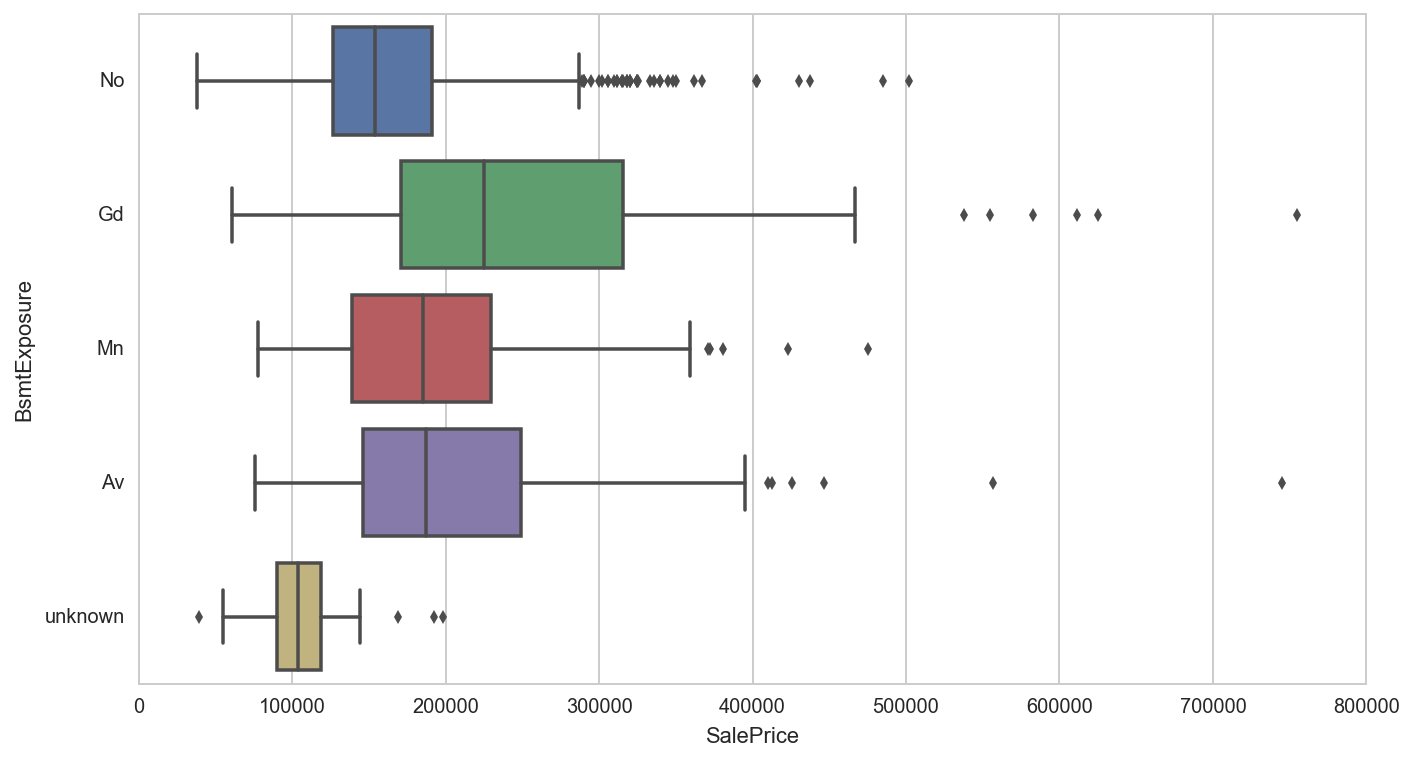

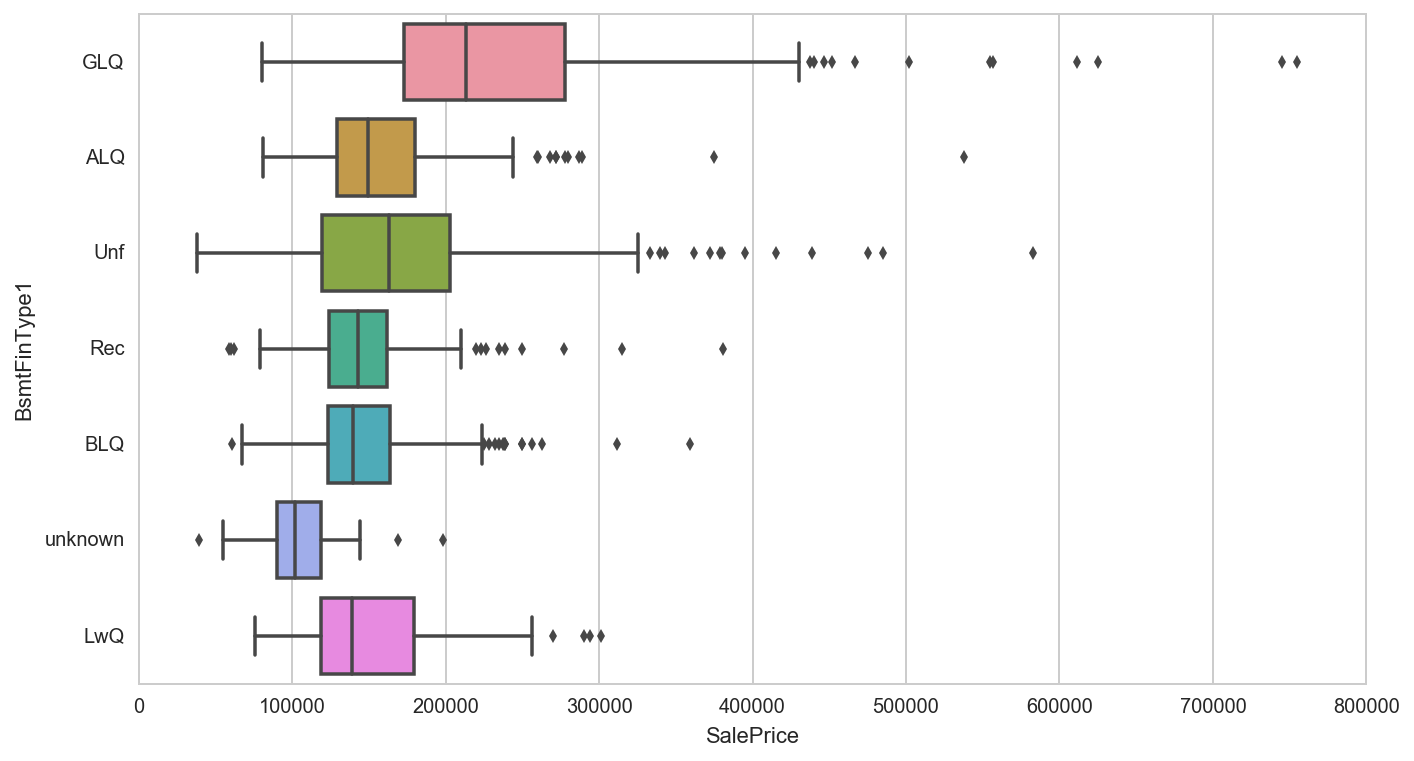

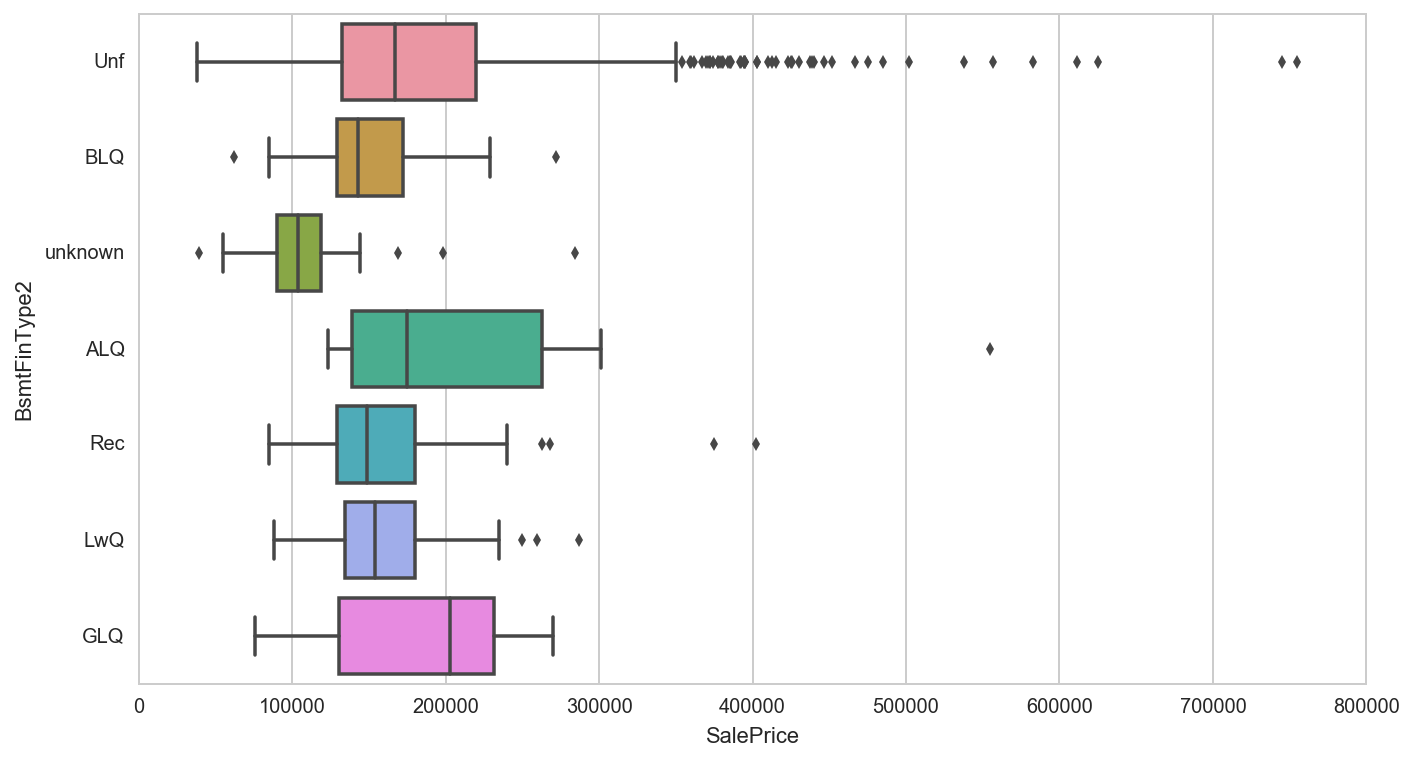

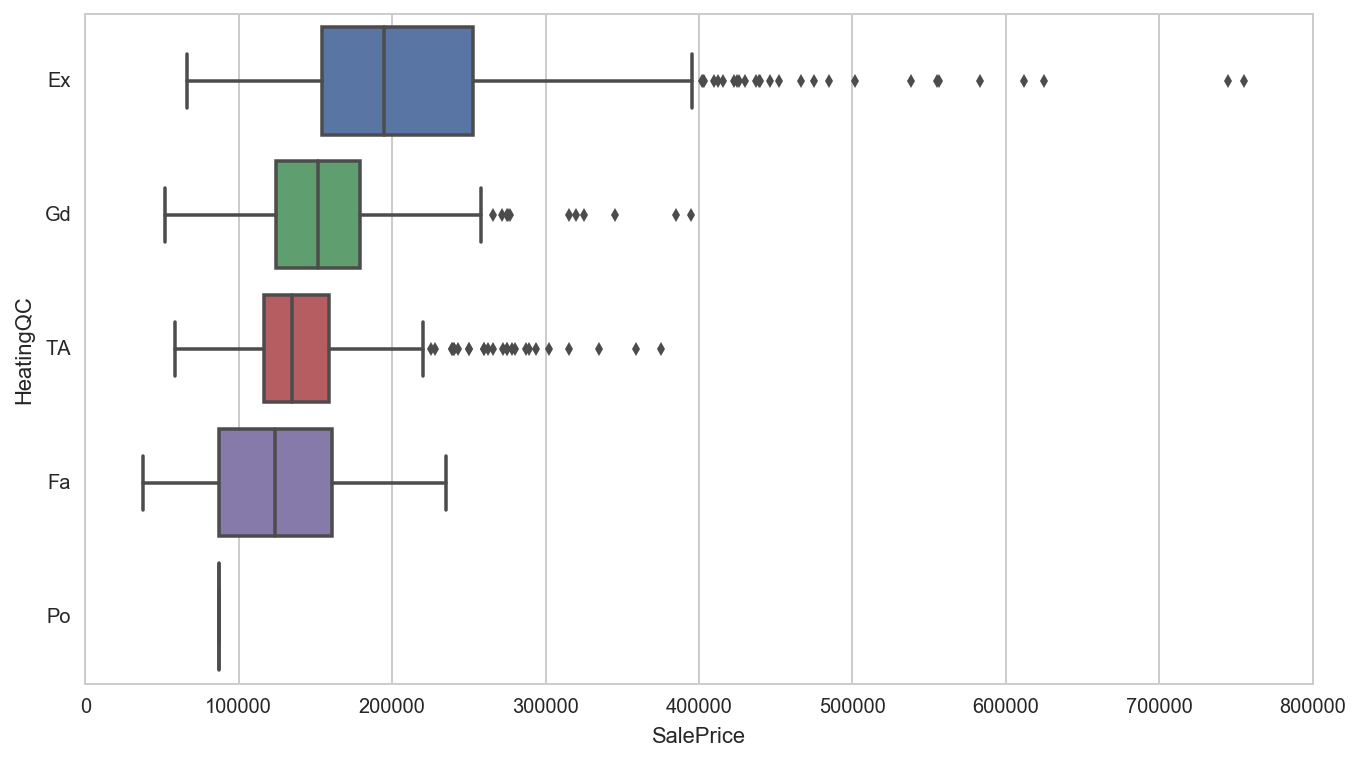

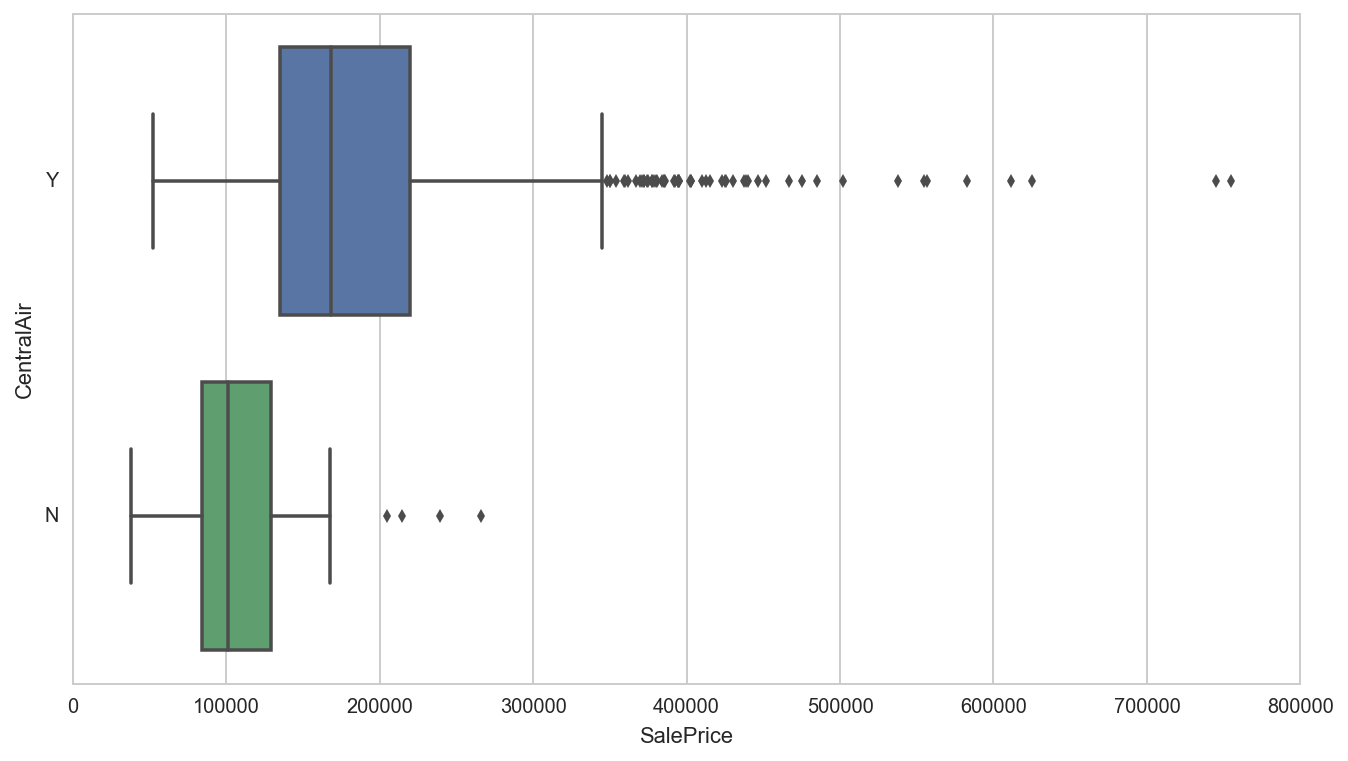

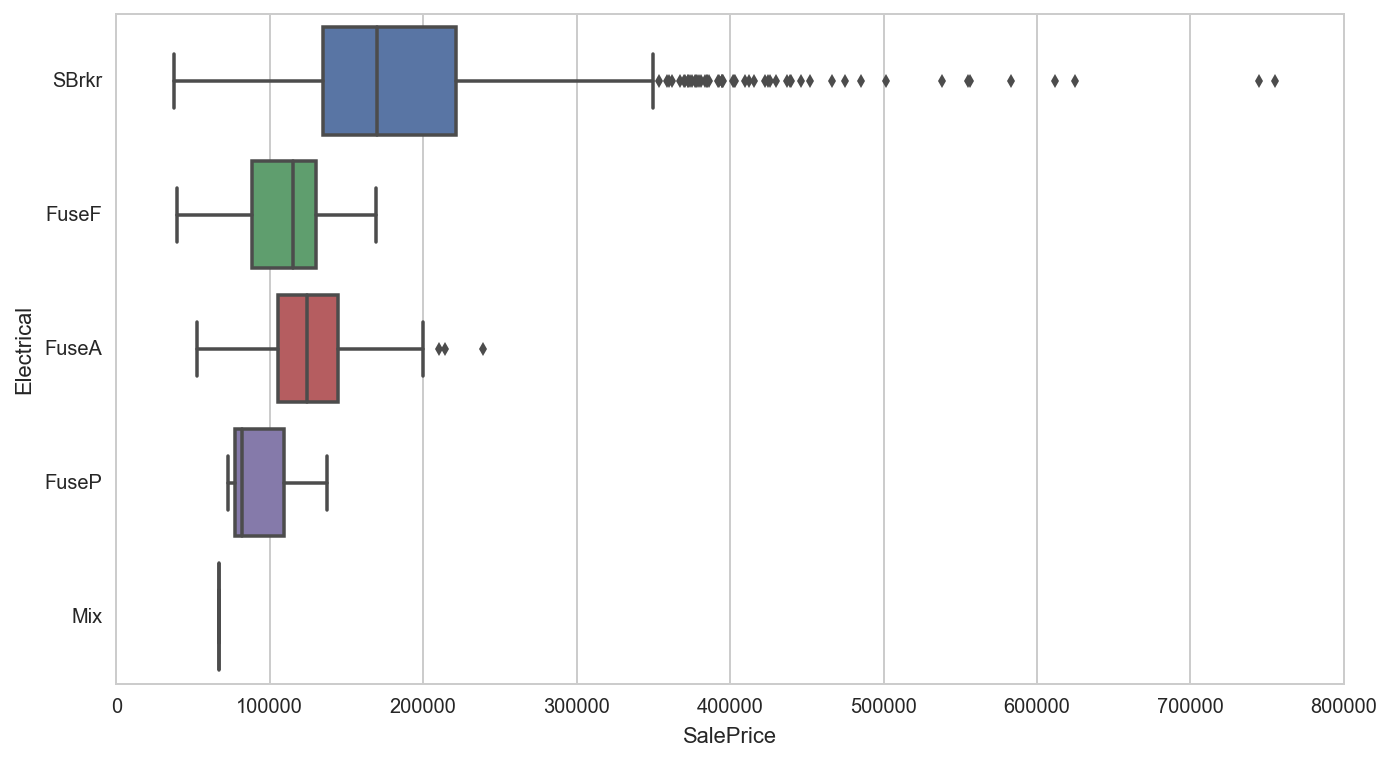

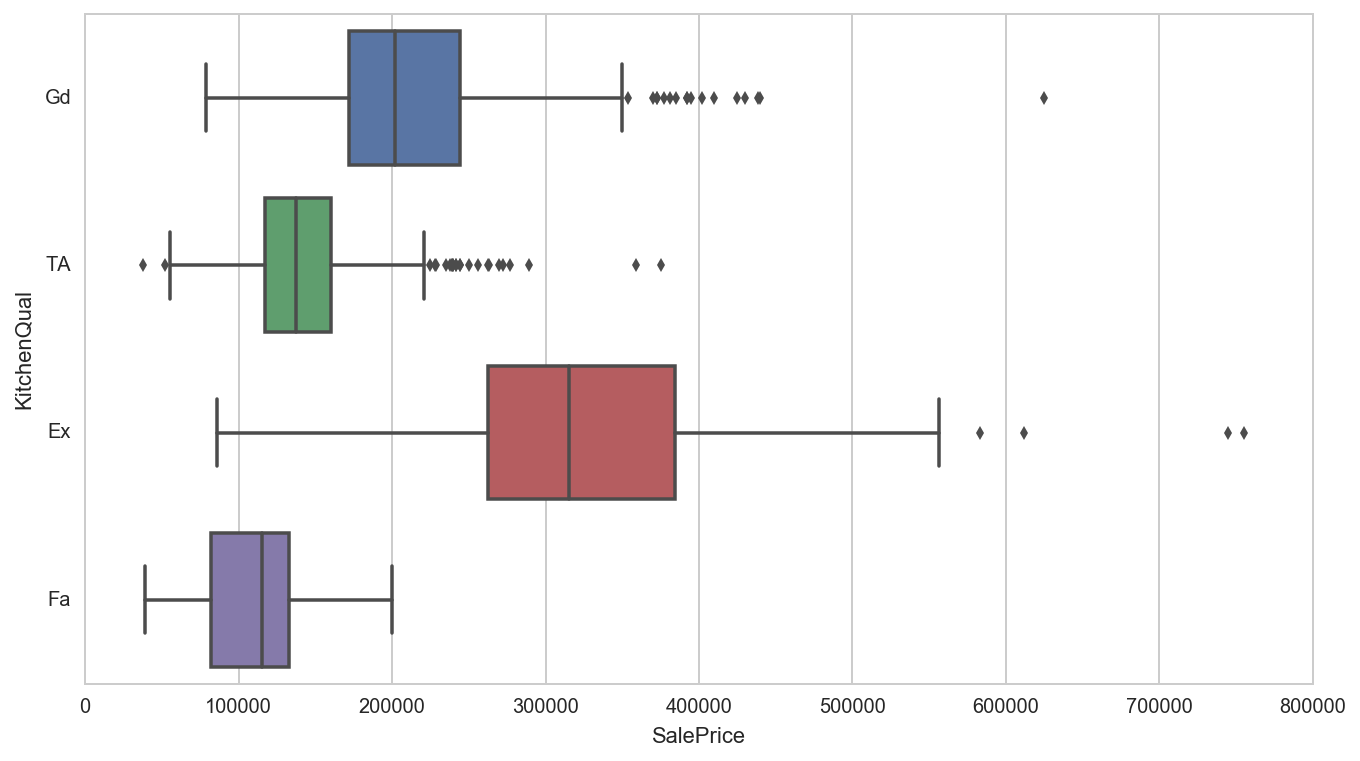

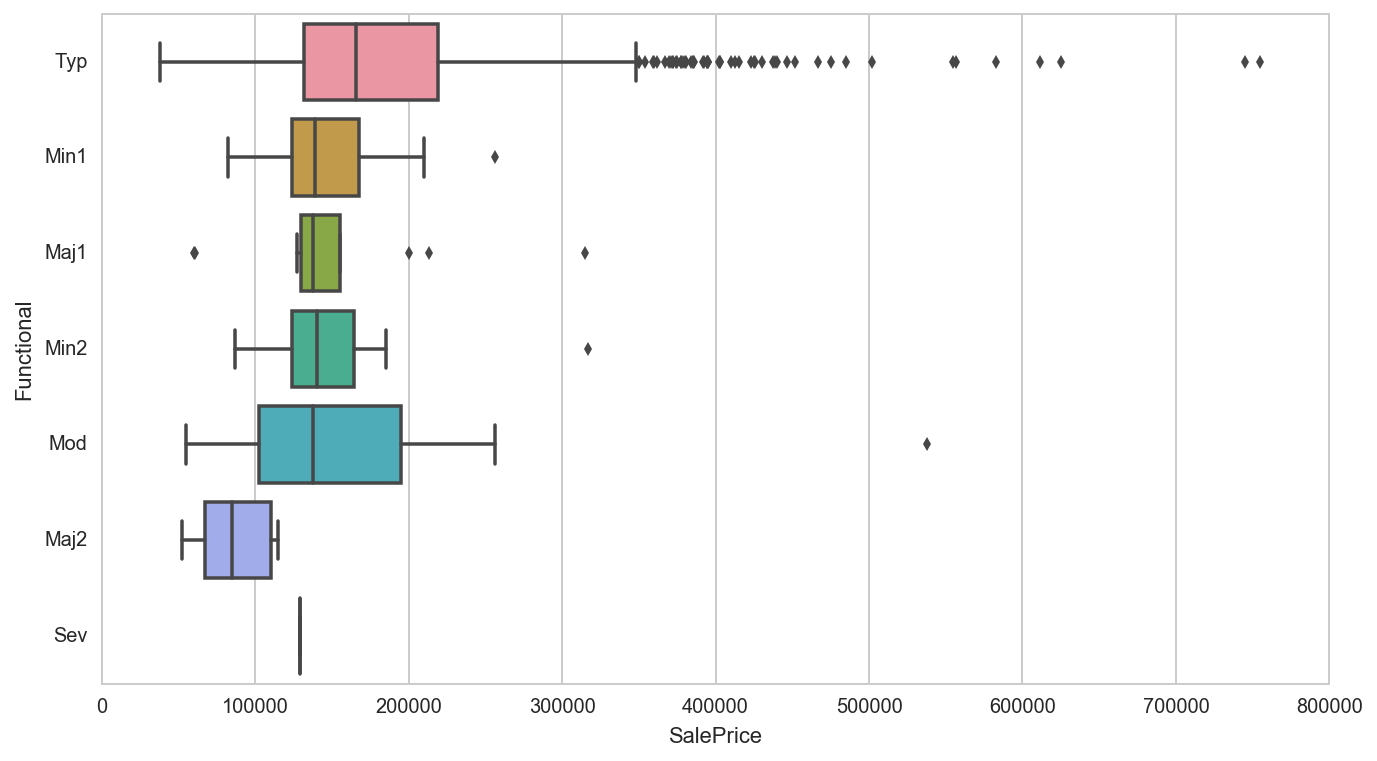

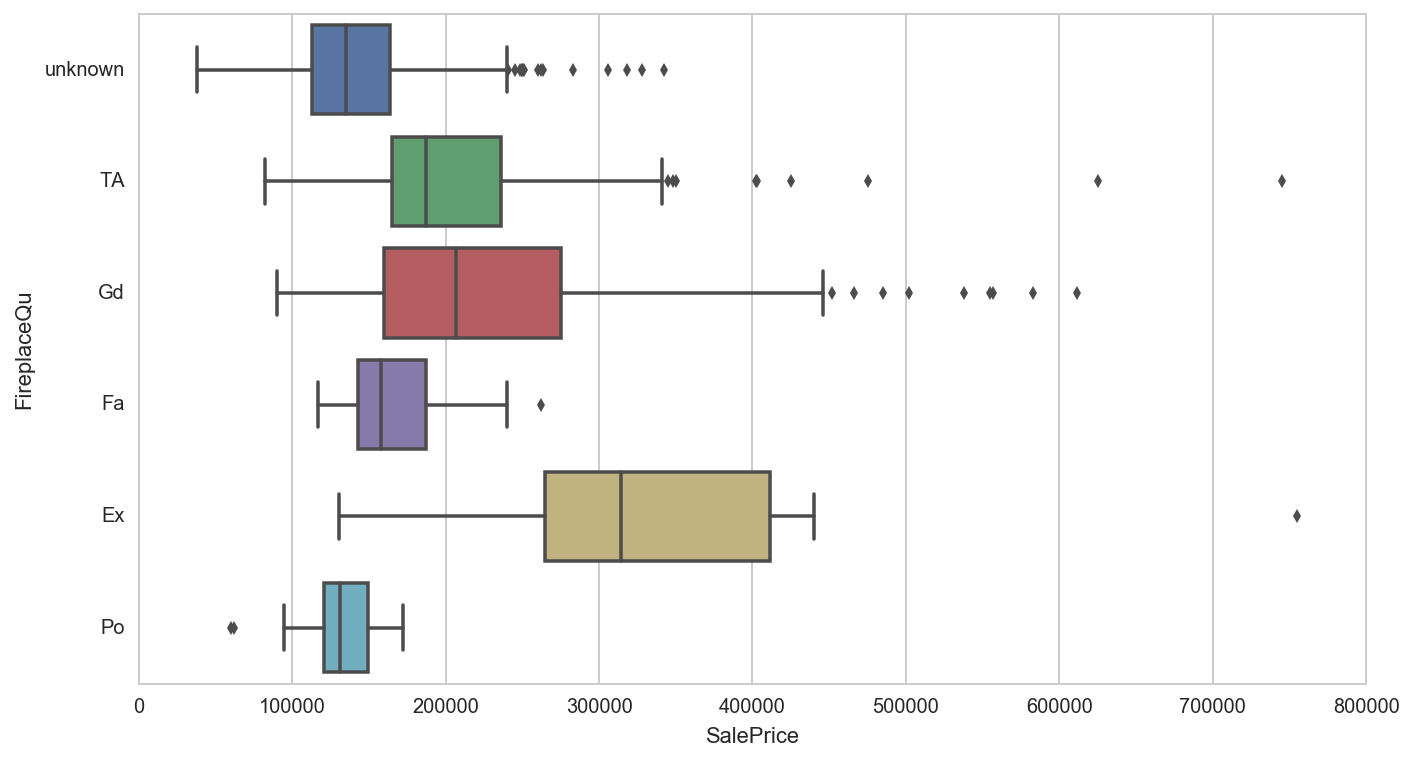

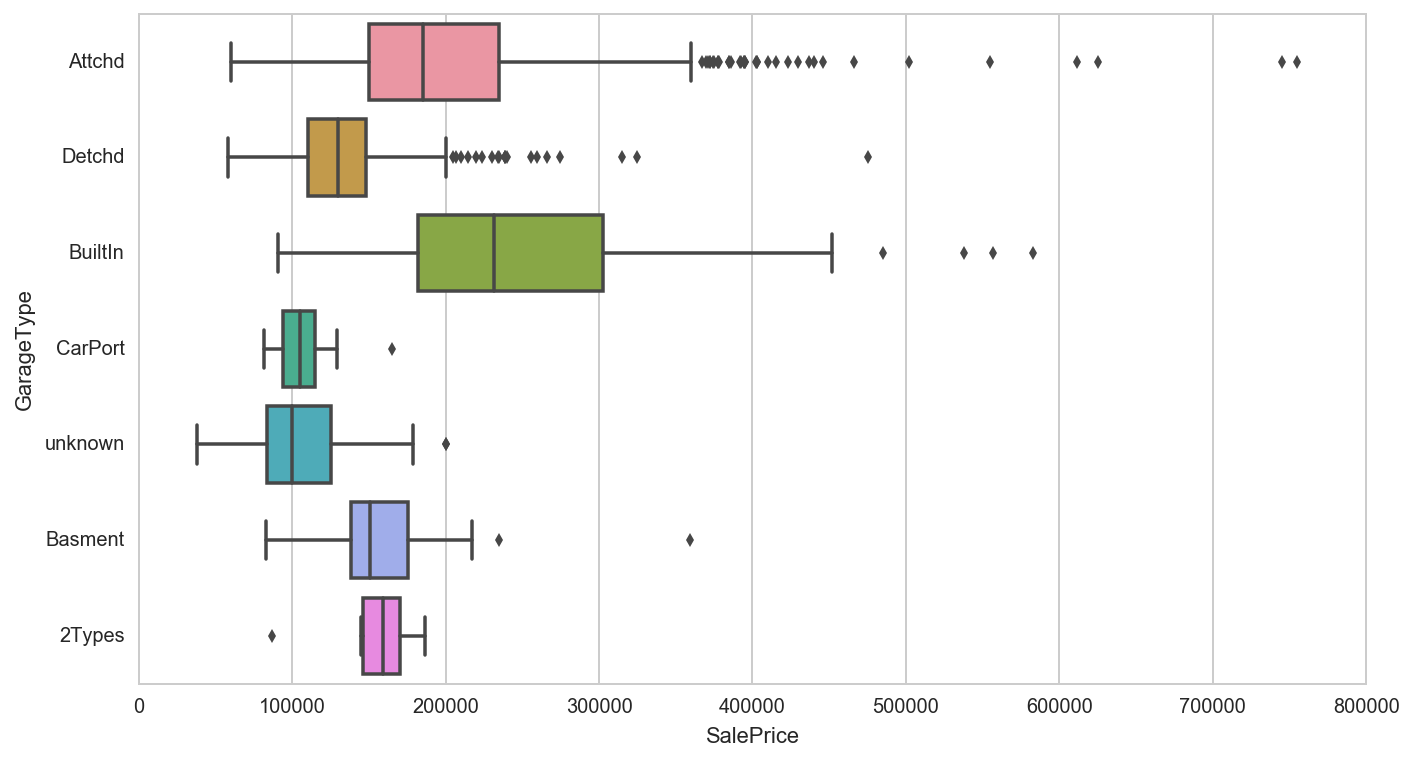

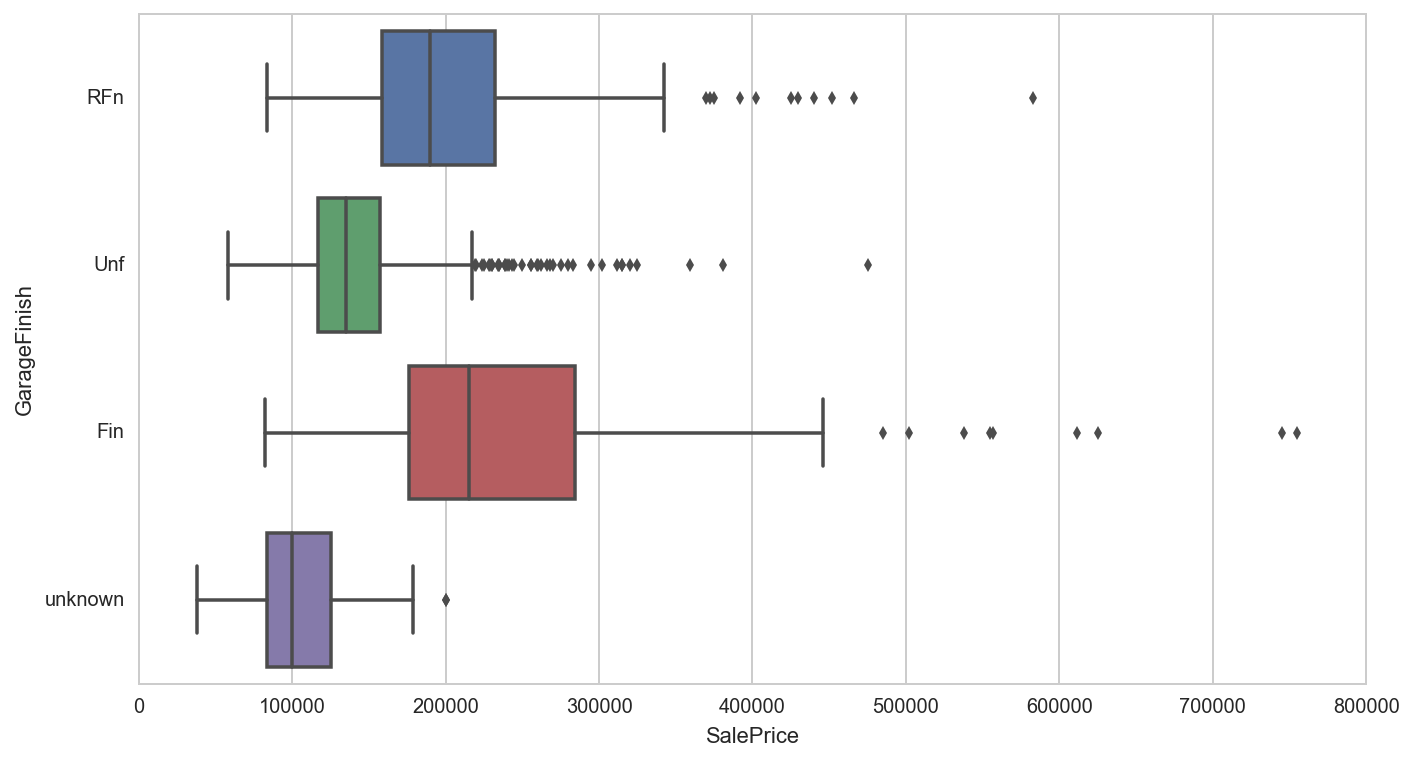

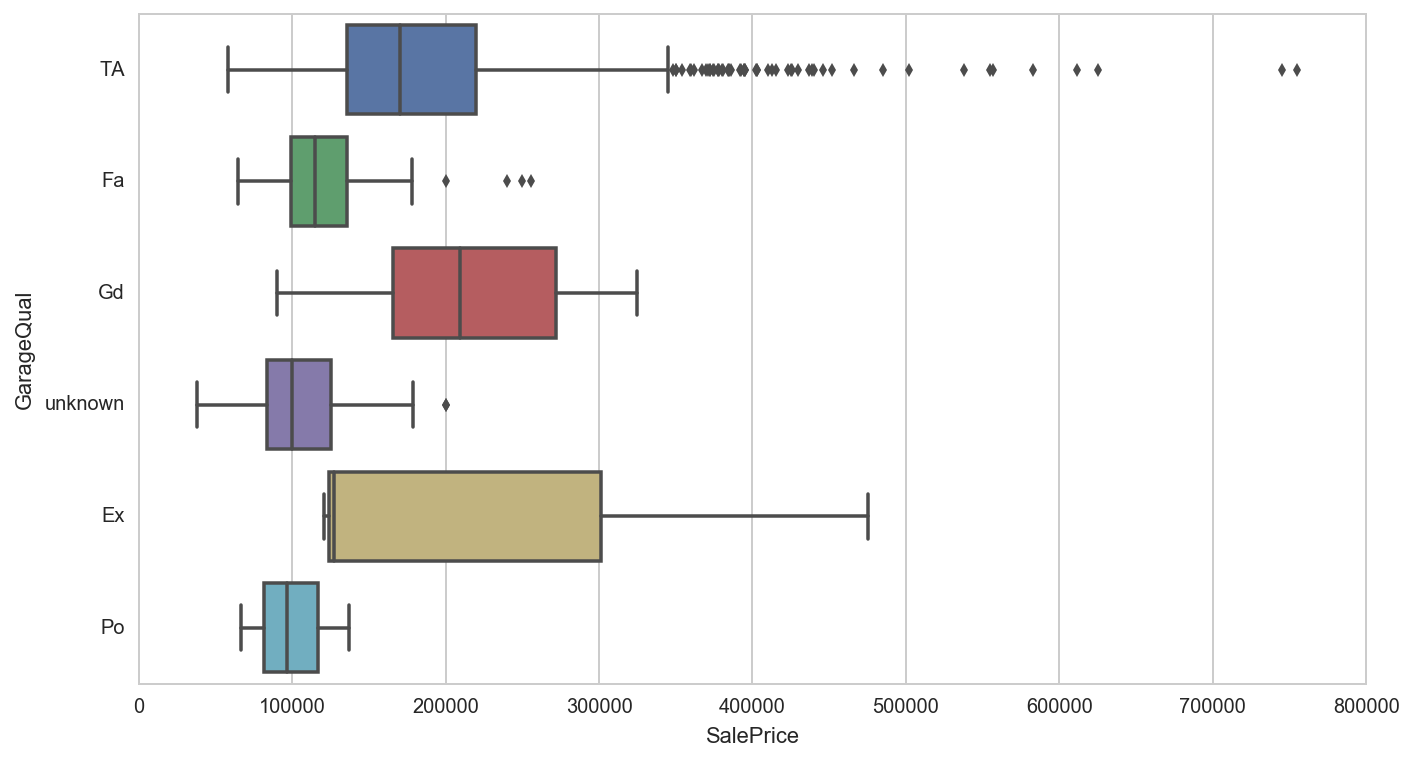

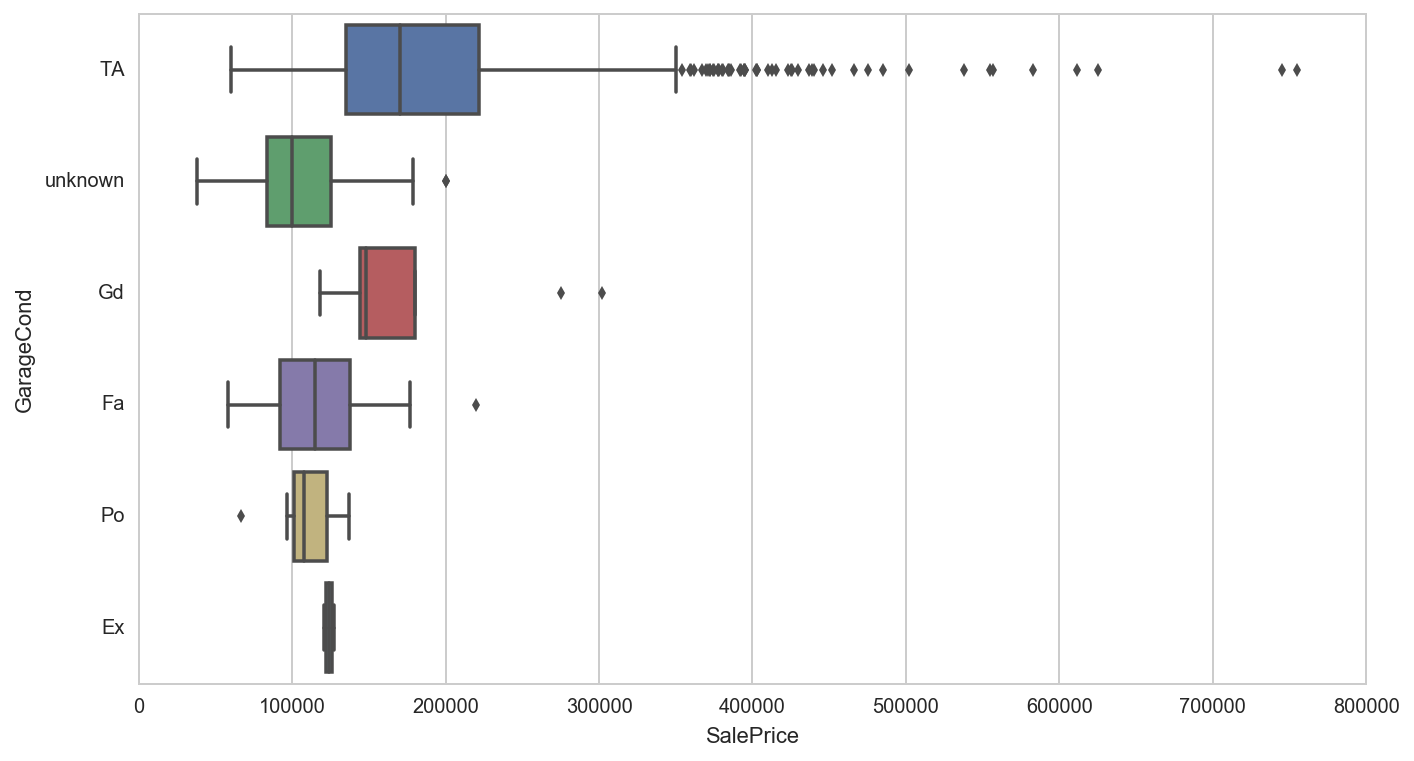

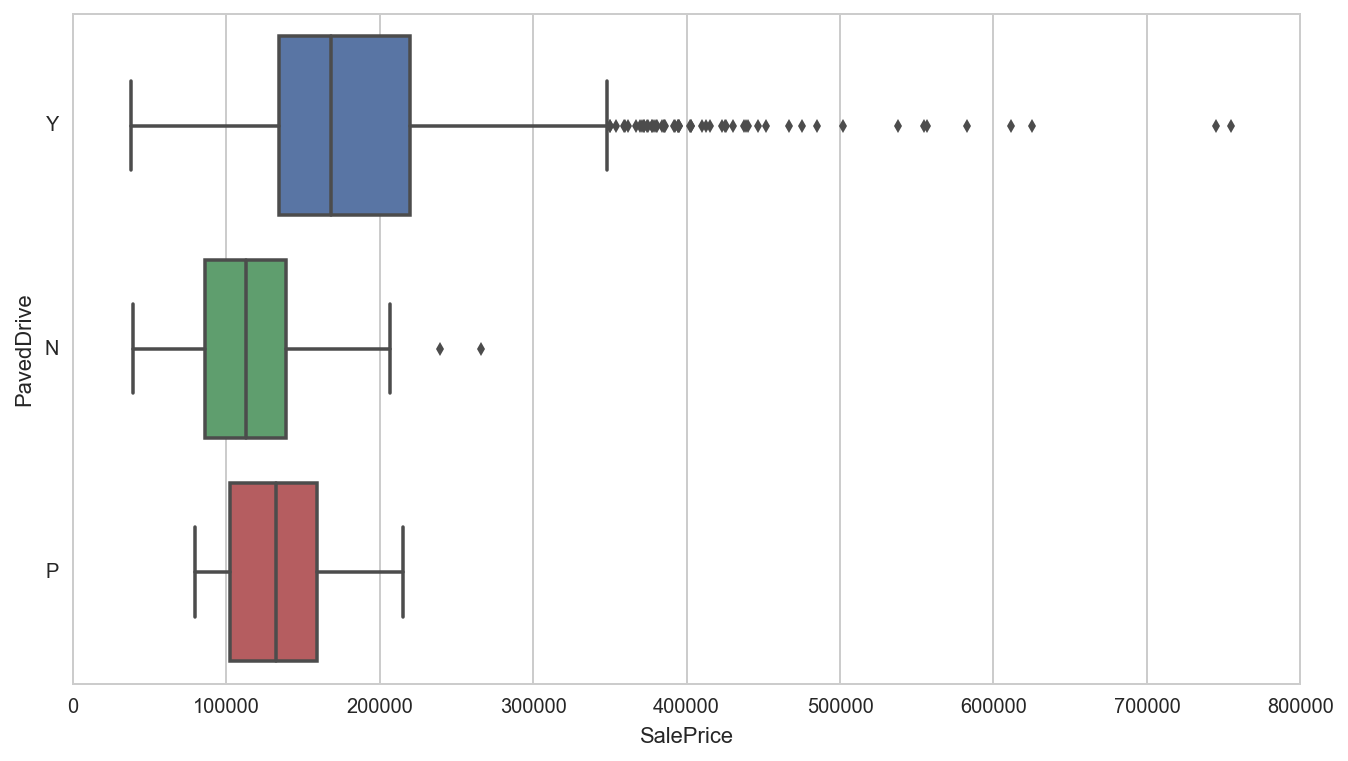

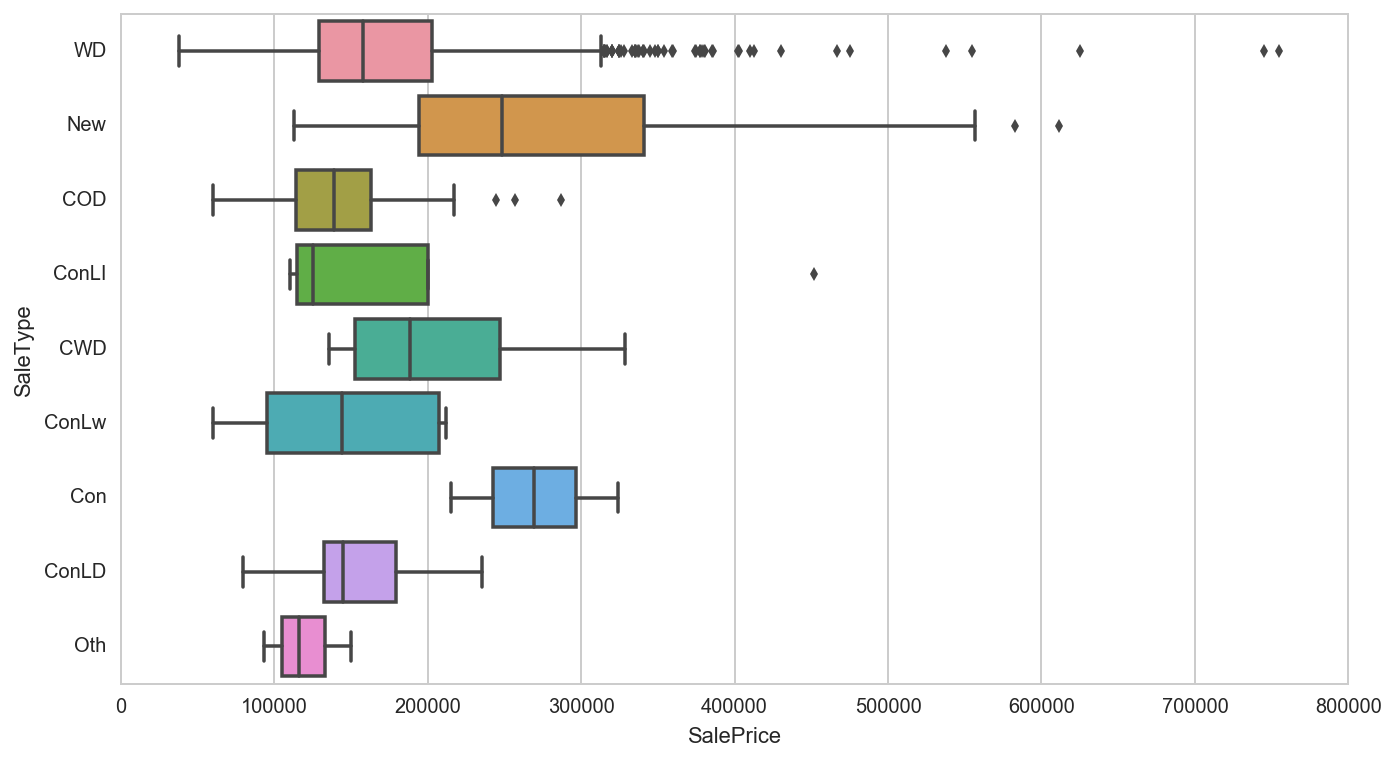

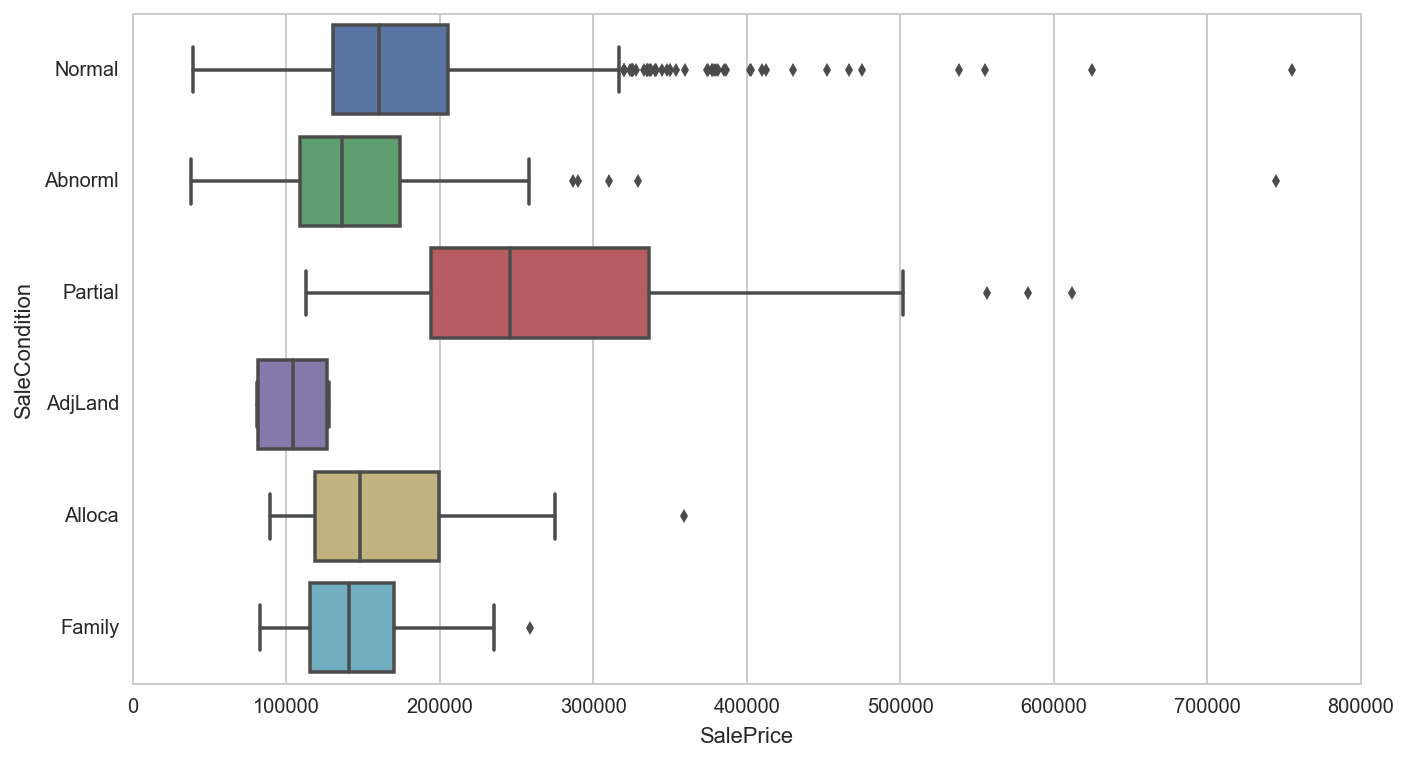

In [41]:
for cat in cat_cols:
    fig, ax = plt.subplots(figsize=(11,6))
    sns.boxplot(x='SalePrice', y=cat, data=house, orient='h', ax=ax)
    plt.show()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 7. Univariate regression predicting price with statsmodels

---

### 7.1 Build a linear regression with statsmodels predicting sales price from total living area sq ft.

Print the results of the regression.


In [42]:
import statsmodels.formula.api as smf

model = smf.ols(formula='SalePrice ~ GrLivArea', data=house)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     1464.
Date:                Mon, 05 Dec 2016   Prob (F-statistic):          1.54e-221
Time:                        19:24:03   Log-Likelihood:                -17790.
No. Observations:                1441   AIC:                         3.558e+04
Df Residuals:                    1439   BIC:                         3.559e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.937e+04   4480.572      4.324      0.000      1.06e+04  2.82e+04
GrLivArea    106.8228      2.792     38.261      0.000       101.346   112.299
==============================================================================
Omnibus:                      259.587   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3544.849
Skew:                           0.400   Prob(JB):                         0.00
Kurtosis:                      10.642   Cond. No.                     4.90e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 7.2 Explain the regression results

What do each of these things represent/mean?

1. The intercept coefficient.
2. The coefficient on GrLivArea.
3. The R-squared value.
4. The p-value for coefficients (P>|t|)

**A:**
1. The intercept coefficient is a constant term added in the estimation of the sale price.
2. The coefficient of GrLivArea is the amount one unit of GrLivArea is multiplied and added to the intercept to estimate the sale price for a given living area.
3. The R-squared value is the percent of variance explained in sale price above baseline by the GrLivArea variable.
4. This represents the probability that the coefficient/effect of GrLivArea is zero given what we see in the model based on our data.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 8. Multivariate regression predicting price with sklearn

---

### 8.1 Build an sklearn linear regression predicting sale price 

Use all of your continuous measures as predictors (no categorical yet).

In [43]:
predictors = [x for x in numeric_cols if not x in ['SalePrice','logSalePrice']]
predictors

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal',
 'MoSold',
 'YrSold',
 'YrAgeWhenSold']

In [44]:
from sklearn.linear_model import LinearRegression

In [45]:
X = house[predictors].values
y = house['SalePrice'].values

In [46]:
linmod = LinearRegression()
linmod.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### 8.2 Calculate the $R^2$ of your model.

In [47]:
linmod.score(X, y)

0.80530228128531145

### 8.3 Plot the residuals against the true values.

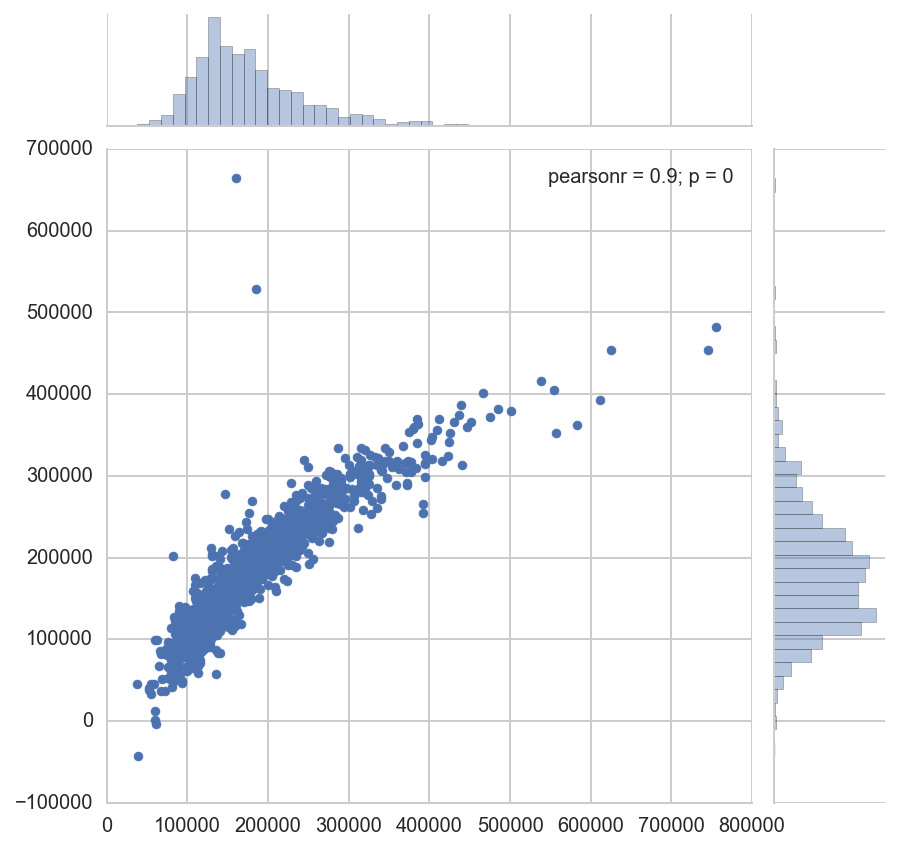

In [48]:
sns.jointplot(y, linmod.predict(X))

### 8.4 Plot a histogram of the residuals.

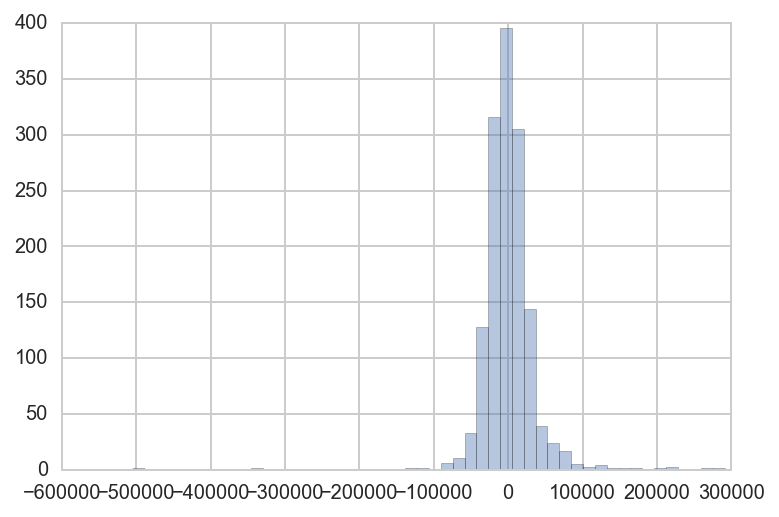

In [49]:
sns.distplot(y-linmod.predict(X), bins=50, kde=False)

### 8.5 Make a plot to show the strength of the different coefficients.

In [50]:
coef_df = pd.DataFrame({
        'predictor':predictors,
        'coef':linmod.coef_
    })

In [51]:
coef_df.sort_values('coef', inplace=True)

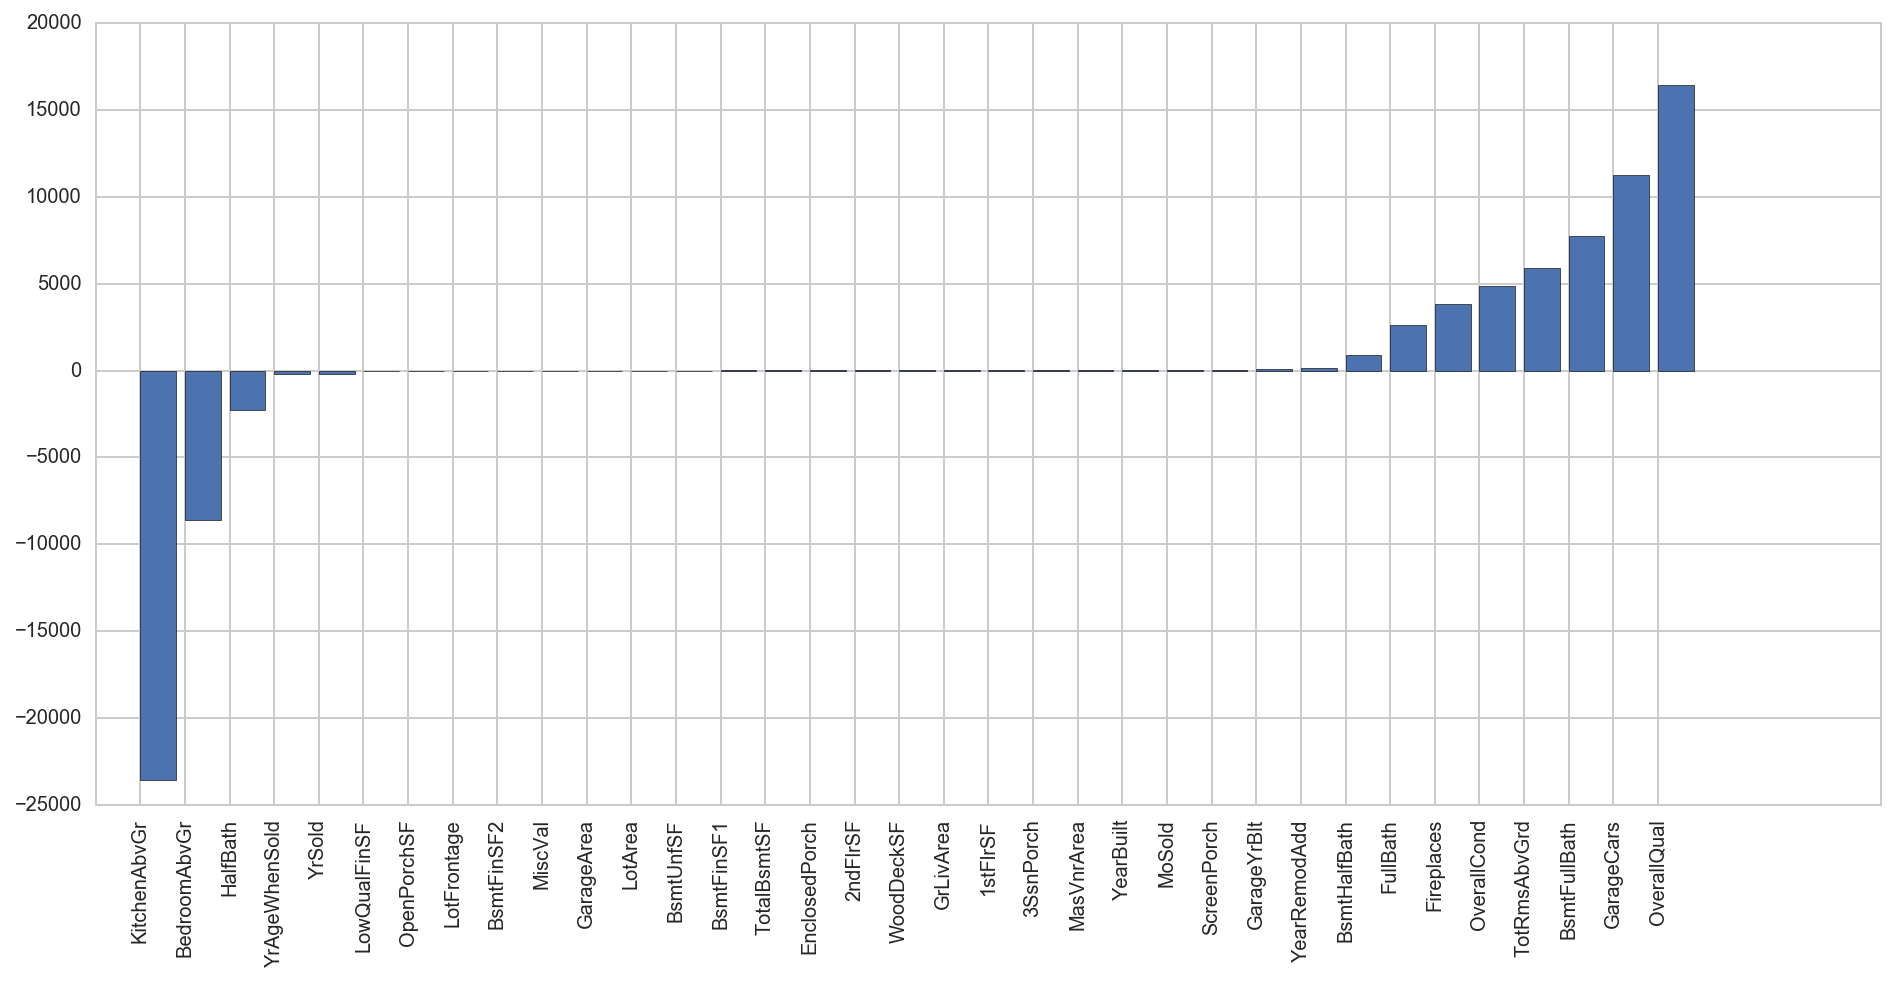

In [52]:
fig, ax = plt.subplots(figsize=(16,7))
ax.bar(range(1, coef_df.shape[0]+1), coef_df.coef, 
       tick_label=coef_df.predictor.values)
ax.set_xticklabels(coef_df.predictor.values, rotation=90)
plt.show()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 9. Create a predictor matrix using all viable predictors available to you

---

You will need to dummy code the categorical variables. This is done most easily using patsy by constructing a formula string to make the matrix, but can be done with sklearn functions or manually as well. 

Recall that the `C(variable)` syntax in patsy formulas will take the column named `'variable'` and make it into dummy coded columns. You may also need to rename columns, patsy has trouble with column names that start with numbers.

Lastly, remember that you may need to convert your target `y` from a matrix to a vector (patsy outputs it as 2D rather than 1D, which skearn may have trouble with.)

In [53]:
house.rename(columns={'1stFlrSF':'FirstFlrSF', '2ndFlrSF':'SecondFlrSF',
                      '3SsnPorch':'ThreeSsnPorch'}, inplace=True)

In [54]:
formula = "SalePrice ~ "+' + '.join([x for x in house.columns if not x in ['SalePrice','logSalePrice','Id']])+' -1'
formula

'SalePrice ~ MSSubClass + MSZoning + LotFrontage + LotArea + LotShape + LandContour + LotConfig + LandSlope + Neighborhood + Condition1 + BldgType + HouseStyle + OverallQual + OverallCond + YearBuilt + YearRemodAdd + RoofStyle + RoofMatl + Exterior1st + Exterior2nd + MasVnrType + MasVnrArea + ExterQual + ExterCond + Foundation + BsmtQual + BsmtCond + BsmtExposure + BsmtFinType1 + BsmtFinSF1 + BsmtFinType2 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + HeatingQC + CentralAir + Electrical + FirstFlrSF + SecondFlrSF + LowQualFinSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr + KitchenQual + TotRmsAbvGrd + Functional + Fireplaces + FireplaceQu + GarageType + GarageYrBlt + GarageFinish + GarageCars + GarageArea + GarageQual + GarageCond + PavedDrive + WoodDeckSF + OpenPorchSF + EnclosedPorch + ThreeSsnPorch + ScreenPorch + MiscVal + MoSold + YrSold + SaleType + SaleCondition + YrAgeWhenSold -1'

In [55]:
import patsy

In [56]:
y, X = patsy.dmatrices(formula, data=house, return_type='dataframe')
y = y.values.ravel()

In [57]:
X.shape, y.shape

((1441, 245), (1441,))

### 9.2 Fit a linear regression using all of the predictors and score it.

In [58]:
linmod = LinearRegression()
linmod.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [59]:
linmod.score(X, y)

0.92041321995423475

### 9.3 Explain why this model and associated $R^2$ score may not be as "good" as they seem.

_The model is likely to be dramatically overfit with 245 predictors. A lot of this 92 R^2 is probably such a good fit due to leveraging spurious noise in the data to get a better fit._

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 10. Cross-validate the model

---

Use 20 folds and calculate the average $R^2$ of your model that has all of the predictors in it.

In [60]:
from sklearn.cross_validation import cross_val_score

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [61]:
avg_r2 = cross_val_score(linmod, X, y, cv=20)

In [62]:
print np.mean(avg_r2)

0.649705147559


In [63]:
avg_r2

array([ 0.91812619, -0.94287428,  0.90397867, -0.28514051,  0.91242165,
        0.89142903,  0.91190812,  0.42929136,  0.88383079,  0.88499543,
        0.91243039,  0.86143411,  0.88436408,  0.8914966 ,  0.87620371,
        0.89171986,  0.82364154, -0.45091734,  0.87768108,  0.91808248])

### 10.2 What does the cross-validated average $R^2$ tell you?

_The model is still surprisingly good - I thought it would be much more overfit and achieve a lower R2. Nevertheless, it is overfit and the R2 drops down to about 65. There are some negative R2 values in the cross-validated score, which also indicates the model is overfit._

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 10.3 When can you have a negative $R^2$ score? Explain what it means.


_You can have a negative R2 when the model you test on out-of-sample data performs worse than the baseline. This typically happens when a model is very overfit. The predictions are so far off that you would have been better off using the mean of the response variable from the training data._

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 11. Construct a Lasso regression and find the optimal regularization strength

---

Now you'll fit a Lasso regression using again the full predictor matrix. 

### 11.1 Using either `LassoCV` or `GridSearchCV` with `Lasso`, find the optimal regularization strength.

You are finding the best `alpha` to use with this data. For `LassoCV` you can use the `n_alphas` parameter to specify how many possible alphas you want the model to search over. With `GridSearchCV` you will have to give it a vector of the alphas you want to try.

Note that in both cases you will need to specify the number of cross-validation folds `cv`. 10 is generally a good number of folds. 

**Remember that you must standardize your predictor matrix when using regularization!**

In [64]:
from sklearn.linear_model import LassoCV, Lasso, RidgeCV
from sklearn.preprocessing import StandardScaler

In [66]:
lassocv = LassoCV(n_alphas=300, cv=10)

In [67]:
Xn = StandardScaler().fit_transform(X)

In [68]:
lassocv.fit(Xn, y)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [69]:
lassocv.alpha_

642.238140075616

### 11.2 Construct a `Lasso` model with the optimal `alpha` and cross-validate the $R^2$.

In [70]:
lasso = Lasso(alpha=lassocv.alpha_)
lasso_r2s = cross_val_score(lasso, Xn, y, cv=20)
print lasso_r2s
print np.mean(lasso_r2s)

[ 0.92939445  0.90497547  0.90764362  0.93264028  0.8884863   0.91692148
  0.88989321  0.62478442  0.885699    0.86529023  0.89889363  0.87058411
  0.85088182  0.89833961  0.84902353  0.88497974  0.79793477 -0.16073754
  0.88248335  0.91505268]
0.821658208799


<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 11.3 Explain the effect of the Lasso regularization and why it can be useful.

_The lasso penalty is good for feature selection. It will set variables to zero as the strength of the penalty increases. This is particularly useful when you have a ton of features, most of which are noise or otherwise not useful for predicting your target variable._

### 11.4 Print out the variables with non-zero Lasso coefficients (with the coefficient).

How many variables remain? 

Tell a (brief) story about what is important for estimating price based on the variables and their coefficients. Just pick out the things most interesting to you.

In [75]:
lasso.fit(Xn, y)

lasso_coef = pd.DataFrame({
        'variable':X.columns,
        'coef':lasso.coef_,
        'abscoef':np.abs(lasso.coef_)
    })

lasso_coef.sort_values('abscoef', ascending=False, inplace=True)
lasso_coef[lasso_coef.coef != 0].head(25)

# The most important variables for predicting the price of the house, as found by the 
# lasso regression, are:
# 1. Living area
# 2. Overall quality
# 3. Neighborhood NridgHt
# 4. Kitchen quality (a couple categories have negative coefficients)
# 5. Cars in garage
#
# There are a lot of neighborhoods that have a decently large impact on the price of
# the house, in the many thousands of dollars per standard deviation.
# The space is by far the biggest coefficient. I'm surprised to not see the bedrooms
# and bathrooms up higher. Quality is no surprise here, nor is cars per garage.

,abscoef,coef,variable
224,23331.445773,23331.445773,GrLivArea
212,14127.157346,14127.157346,OverallQual
45,8610.617815,8610.617815,Neighborhood[T.NridgHt]
163,8102.486808,-8102.486808,KitchenQual[T.Gd]
164,7883.368574,-7883.368574,KitchenQual[T.TA]
234,7596.858427,7596.858427,GarageCars
44,7380.061826,7380.061826,Neighborhood[T.NoRidge]
130,6878.327228,-6878.327228,BsmtQual[T.Gd]
51,6285.570567,6285.570567,Neighborhood[T.StoneBr]
84,6208.907509,6208.907509,RoofMatl[T.WdShngl]


In [76]:
# Over 50% of the variables were set to zero.
np.sum(lasso.coef_ == 0)/float(len(lasso.coef_))

0.54285714285714282

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 12. Construct a Ridge regression and find the optimal regularization strength

---

### 12.1 Create a predictor matrix of only variables related to sq. ft.

**Remember that you must standardize your predictor matrix before using Ridge regularization.**

In [77]:
sf_preds = [x for x in house.columns if 'SF' in x]+['LotArea','LotFrontage']
sf_preds

['BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'FirstFlrSF',
 'SecondFlrSF',
 'LowQualFinSF',
 'WoodDeckSF',
 'OpenPorchSF',
 'LotArea',
 'LotFrontage']

### 12.2 Plot a correlation matrix of your predictors. Why might Ridge be useful here?

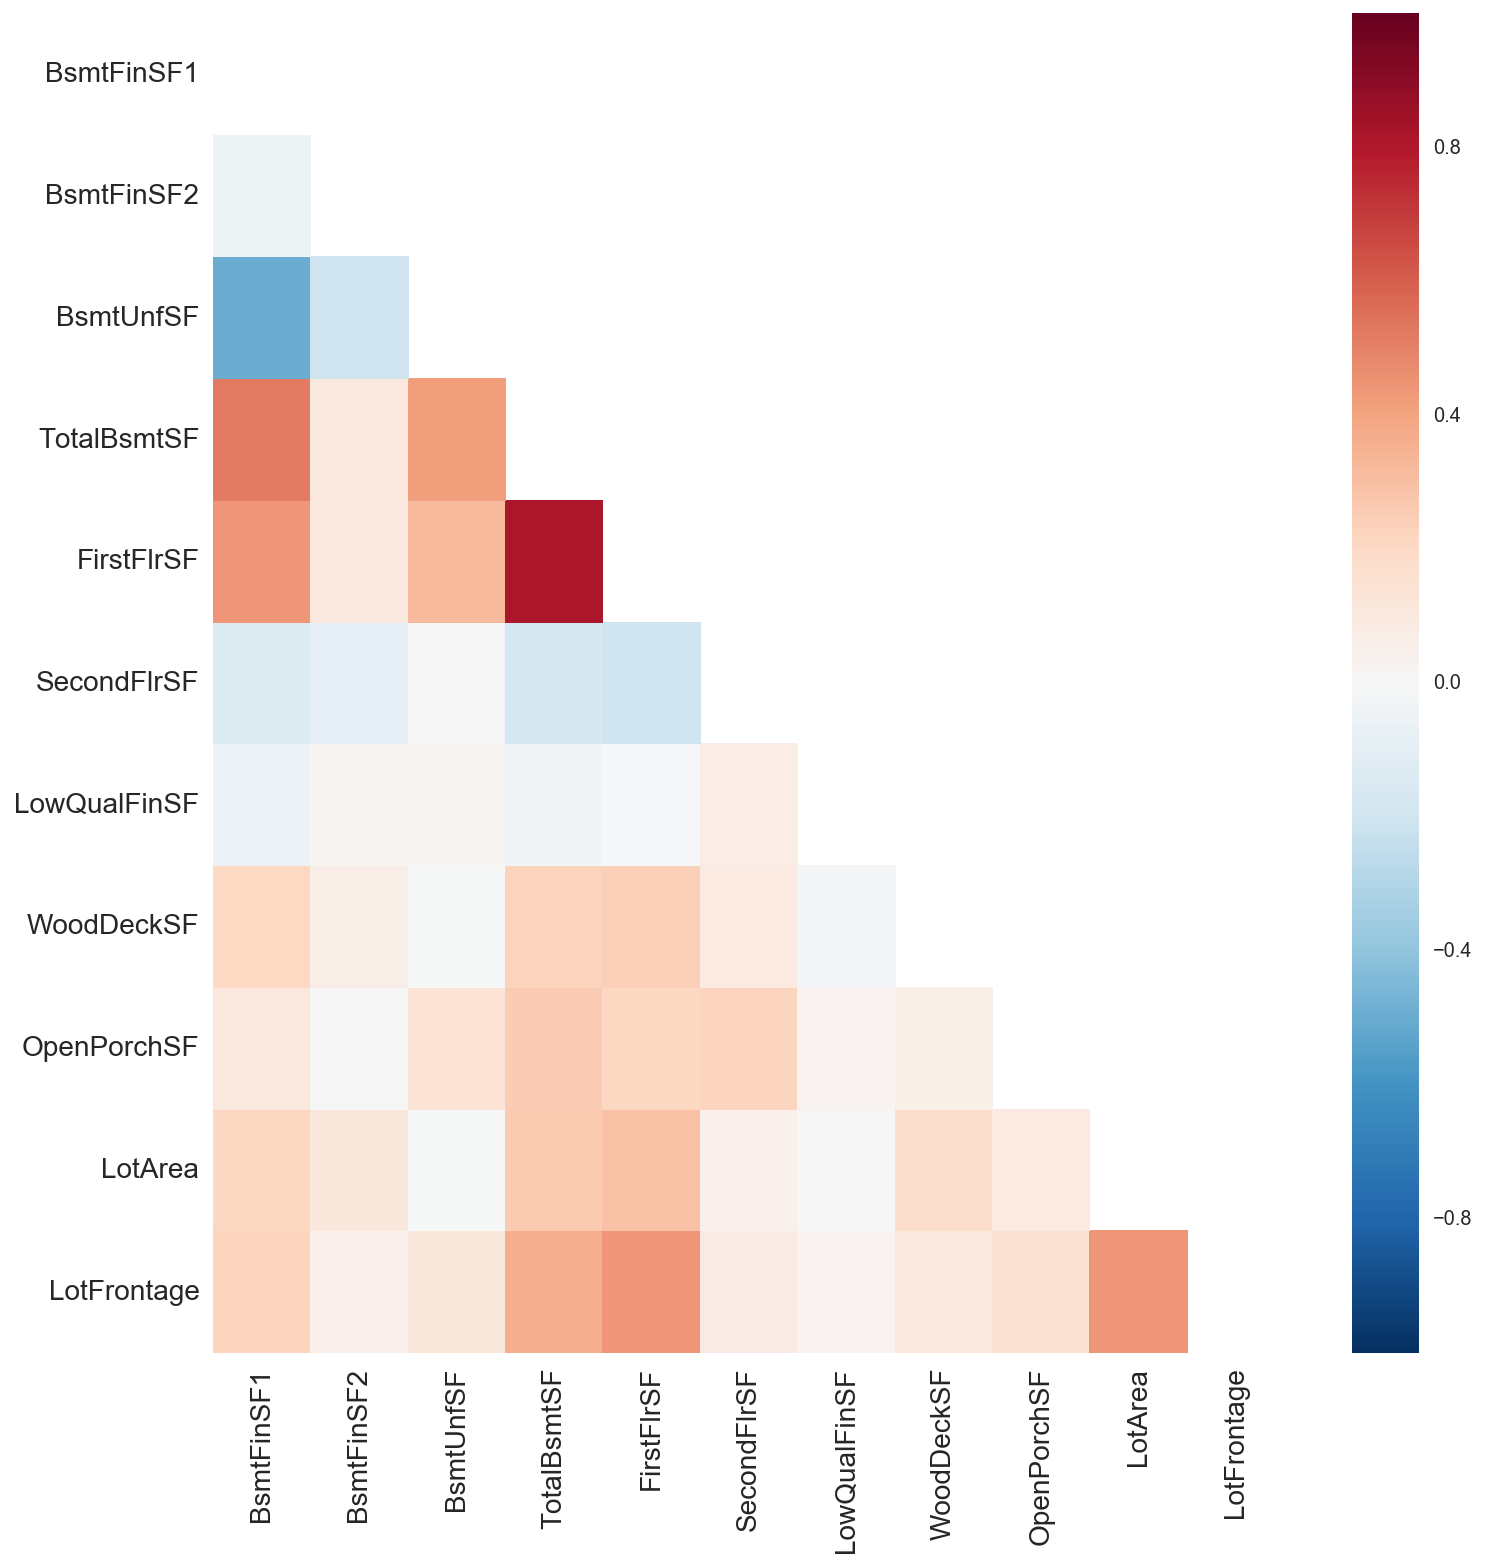

In [78]:
numeric_subset = house[sf_preds]
corrs = numeric_subset.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(12,12))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrs, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [79]:
# Ridge may be useful here because there is a fair amount of multicollinearity in the dataset.

### 12.3 Find the optimal Ridge `alpha` using either `RidgeCV` or a combination of `GridSearchCV` and `Ridge`.



In [82]:
ridge_cv = RidgeCV(alphas=np.logspace(-2, 5, 400), cv=10)

Xn_ridge = house[sf_preds]
Xn_ridge = StandardScaler().fit_transform(Xn_ridge)
y_ridge = house.SalePrice.values

In [83]:
ridge_cv.fit(Xn_ridge, y_ridge)

RidgeCV(alphas=array([  1.00000e-02,   1.04122e-02, ...,   9.60409e+04,   1.00000e+05]),
    cv=10, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [84]:
print ridge_cv.alpha_

75.369039809


### 12.4 Compare the cross-validated $R^2$ score for a standard Linear Regression and your Ridge regression

In [87]:
from sklearn.linear_model import Ridge 

lr = LinearRegression()
ridge = Ridge(alpha=ridge_cv.alpha_)

print 'linreg R2:', np.mean(cross_val_score(lr, Xn_ridge, y_ridge, cv=20))
print 'ridge R2:', np.mean(cross_val_score(ridge, Xn_ridge, y_ridge, cv=20))

linreg R2: 0.555753181351
ridge R2: 0.562833344425


In [ ]:
# Turns out ridge is only marginally better with 20 fold cross-validation. Probably
# not worth it in this case.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 13. Explain the difference between Ridge and Lasso regularization

---

When are good scenarios to use each? Why do they have the effects they do on coefficients?

**A:**

The Lasso penalty adds the sum of the absolute values of the (non-intercept) beta coefficients to the least squares loss function. This means that the larger coefficients get, the more they contribute to the loss. This is true for the Ridge penalty as well, but in the case of the ridge it is the sum of squared betas that is added to the loss function.

The effect of the lasso is that coefficients get "zeroed out" in order of their importance to the prediction. Those variables that contribute more to a better prediction are retained longer, and variables that are marginally predicting get eliminated. This is good for variable selection, such as when you have hundreds or thousands of variables.

The Ridge is good for multicollinearity. It shrinks coefficients down so that correlated predictors are able to "share" the variance of the target variable. This leads to more stable coefficients and results across different subsets of the data, and allows for more highly correlated variables to both be present in the regression together.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 14. Gridsearch an optimal `ElasticNet` regression.

---

On the full predictor matrix, search for the optimal hyperparameters for an Elastic Net regression. Remember that the Elastic net is a mixture of the Ridge and Lasso, and has both an `alpha` parameter to regularize as well as an `l1_ratio`, which is the balance of Lasso vs. Ridge.

How does the ElasticNet compare to the Lasso on the dataset? What does the `l1_ratio` tell you about the balance of Ridge vs. Lasso in your model?

In [89]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

enet_cv = ElasticNetCV(l1_ratio=np.linspace(0.01, 1., 50), n_alphas=300, cv=10, verbose=1)
enet_cv.fit(Xn, y)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=array([ 0.01   ,  0.0302 ,  0.05041,  0.07061,  0.09082,  0.11102,
        0.13122,  0.15143,  0.17163,  0.19184,  0.21204,  0.23224,
        0.25245,  0.27265,  0.29286,  0.31306,  0.33327,  0.35347,
        0.37367,  0.39388,  0.41408,  0.43429,  0.45449,  0.47469,
        0.4949 ,  0.515...3837,
        0.85857,  0.87878,  0.89898,  0.91918,  0.93939,  0.95959,
        0.9798 ,  1.     ]),
       max_iter=1000, n_alphas=300, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=1)

In [90]:
print enet_cv.l1_ratio_
print enet_cv.alpha_

1.0
642.238140076


In [91]:
# My elastic net CV just chose an l1_ratio of 1, meaning that it defaulted entirely to the Lasso penalty!

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 15. Further fine-tune the model to predict price

---

Your goal is to create the model with the best predictive power.

You can use as much feature engineering and transformation of variables that you want, but please limit yourself to using the regression models we have covered in class thus far. When we cover models like Random Forests and Gradient Boosted Trees we will return to this dataset and see how they compare to the regression models.

For those that tackle this problem, you will have a chance to show what you did and compare to what your other classmates came up with during class (if you want). **Feel free to collaborate with your classmates on improving the model!**